here is a list of the classification models:
Classicial machine learning models
- Decision trees (DT)
- Random forest (RF)
- Gradient boosting (XGB)
- Support vector machines (SVM)
- Artificial Neuro-Fuzzy System (ANFIS)- 0 order - gradient descent (GD)
- ANFIS-1 - 1st order - gradient descent (GD)
- ANFIS- 0 order - stochastic gradient descent (SGD)
- ANFIS-1 - 1st order - stochastic gradient descent (SGD)
- ANFIS-based Pytsk-0 order - mini batch gradient descent MBGD 
- ANFIS-based Pytsk-1 - mini batch gradient descent MBGD 

Other Abbreviations:

(KM: K-means clustering, lr: learning rate, GP: grid partitioning, L2: ridge regularization, SMOTE: synthetic minority over sampling, std: standard deviation.)

In [ ]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, recall_score
import xgboost as xgb
from xgboost import XGBClassifier
import optuna
import tqdm
import time
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.metrics import f1_score, average_precision_score
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.datasets import load_iris
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
import pickle
from sklearn.metrics import log_loss
from sklearn.linear_model import SGDClassifier
from sklearn.datasets import make_classification
from torch.optim import AdamW
from pytsk.gradient_descent.antecedent import AntecedentGMF, antecedent_init_center
from pytsk.gradient_descent.callbacks import EarlyStoppingACC
from pytsk.gradient_descent.training import Wrapper
from pytsk.gradient_descent.tsk import TSK
from pytsk.gradient_descent import EvaluateAcc

In [2]:
import pickle
def save_model(self, filename):
    with open(filename, 'wb') as file:
        pickle.dump(self, file)
    print(f'Model saved to {filename}')

In [3]:
%%time
# import dataset

# Define the file path
file_path = r'C:\Users\qaboshama\Desktop\ANFIS\df_10features_extracted.csv'

# Load the CSV file into a DataFrame
df = pd.read_csv(file_path)

# Display the first few rows of the DataFrame
df.head()


CPU times: total: 1.14 s
Wall time: 1.12 s


,Label,PNode_2_max,PNode_2_mean,PNode_2_min,PNode_10_mean,PNode_32_mean,PNode_31_mean,PNode_23_mean,PNode_12_mean,PNode_13_mean,PNode_22_mean
0,0.0,45.72,44.440146,36.576,108.753438,99.987896,103.336000,107.095417,104.687104,105.753479,105.671208
1,0.0,45.72,45.720000,45.720,117.341688,111.765146,114.762854,118.958812,116.590021,117.638979,117.512542
2,0.0,45.72,45.720000,45.720,117.163417,111.524875,114.526292,118.731625,116.361604,117.409729,117.283021
3,0.0,45.72,45.720000,45.720,117.088125,111.401687,114.411708,118.628062,116.262875,117.305271,117.178167
4,0.0,45.72,45.720000,45.720,116.861583,111.074583,114.074500,118.316917,115.962604,116.994812,116.868583


In [4]:
%%time
df.shape

CPU times: total: 0 ns
Wall time: 0 ns


(729999, 11)

## Normalization

In [5]:

# Separate features and label
X = df.drop(columns=['Label'])  # Features (all columns except 'Label')
y = df['Label']  # Target (Label)

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the features
X_scaled = scaler.fit_transform(X)

# Create a new DataFrame with the scaled features and the original label
df_scaled = pd.DataFrame(X_scaled, columns=X.columns)
df_scaled['Label'] = y.values

# Display the first few rows of the scaled DataFrame
print("Scaled DataFrame:")
df_scaled.head()




Scaled DataFrame:


,PNode_2_max,PNode_2_mean,PNode_2_min,PNode_10_mean,PNode_32_mean,PNode_31_mean,PNode_23_mean,PNode_12_mean,PNode_13_mean,PNode_22_mean,Label
0,0.332201,0.127012,-1.155290,0.086625,0.095659,0.079080,0.048629,0.012720,0.039180,0.040698,0.0
1,0.332201,0.354838,0.379462,0.516287,0.522519,0.506184,0.505540,0.502594,0.501359,0.508927,0.0
2,0.332201,0.354838,0.379462,0.507368,0.513811,0.497342,0.496790,0.493194,0.492444,0.499852,0.0
3,0.332201,0.354838,0.379462,0.503601,0.509346,0.493059,0.492802,0.489130,0.488382,0.495705,0.0
4,0.332201,0.354838,0.379462,0.492267,0.497490,0.480455,0.480818,0.476772,0.476310,0.483464,0.0


## SMOTE

In [6]:
# check class imbalance ratio
# Calculate the count of each label
label_counts = df_scaled['Label'].value_counts()

# Calculate the ratio of label 1 to label 0
label_1_count = label_counts.get(1, 0)
label_0_count = label_counts.get(0, 0)
ratio = label_1_count / label_0_count if label_0_count > 0 else float('inf')  # Avoid division by zero

print(f"Count of label 1: {label_1_count}")
print(f"Count of label 0: {label_0_count}")
print(f"Ratio of label 1 to label 0: {ratio:.2f}")

Count of label 1: 158651
Count of label 0: 571348
Ratio of label 1 to label 0: 0.28


In [7]:
# split data (i am using numpy here from now on since it is compatible with pytsk)
X = df_scaled.drop(columns=['Label']) 
y = df_scaled['Label']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [9]:
# check class imbalance after smote

# Count occurrences of each class in the resampled training data
class_counts_resampled = Counter(y_train_resampled)

# Print the counts of each class
print("Class counts in the resampled training data:")
print(class_counts_resampled)

# Calculate the ratio of labels 1 to 0
ratio_1_to_0 = class_counts_resampled[1] / class_counts_resampled[0]
print(f"Ratio of labels 1 to 0 in the resampled training data: {ratio_1_to_0:.2f}")


Class counts in the resampled training data:
Counter({0.0: 457019, 1.0: 457019})
Ratio of labels 1 to 0 in the resampled training data: 1.00


## Random forest

In [11]:
%%time
#Initialize and train the Random Forest classifier
rf = RandomForestClassifier(n_estimators=50, random_state=42, verbose=2)
rf.fit(X_train_resampled, y_train_resampled)

building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  4.6min


building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50
CPU times: total: 5min 46s
Wall time: 5min 47s


RandomForestClassifier(n_estimators=50, random_state=42, verbose=2)

In [12]:

# Step 4: Make predictions
y_pred = rf.predict(X_test)

# Step 5: Evaluate the performance
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Compute confusion matrix to get True Positives, False Positives, etc.
conf_matrix = confusion_matrix(y_test, y_pred)

# Extract True Positives, False Positives, True Negatives, and False Negatives
tn, fp, fn, tp = conf_matrix.ravel()

# True Positive Rate (Recall) = TP / (TP + FN)
true_positive_rate = tp / (tp + fn)

# False Positive Rate = FP / (FP + TN)
false_positive_rate = fp / (fp + tn)

# Calculate F1-score
f1 = f1_score(y_test, y_pred)

# Calculate average precision
average_precision = average_precision_score(y_test, y_pred)

# Output the results
print(f"Accuracy: {accuracy}")
print(f"True Positive Rate (Recall): {true_positive_rate}")
print(f"False Positive Rate: {false_positive_rate}")
print(f"F1-Score: {f1}")
print(f"Average Precision: {average_precision}")
print("Classification Report:")
print(report)


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.7s


Accuracy: 0.9438424657534247
True Positive Rate (Recall): 0.8226137475924348
False Positive Rate: 0.022575199643135164
F1-Score: 0.8640411242848852
Average Precision: 0.7869447718154184
Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.98      0.96    114329
         1.0       0.91      0.82      0.86     31671

    accuracy                           0.94    146000
   macro avg       0.93      0.90      0.91    146000
weighted avg       0.94      0.94      0.94    146000



## Decision Tree

In [13]:
%%time
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_resampled, y_train_resampled)

CPU times: total: 31.8 s
Wall time: 31.8 s


DecisionTreeClassifier(random_state=42)

In [14]:

# Step 4: Make predictions
y_pred = dt.predict(X_test)

# Step 5: Evaluate the performance
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Compute confusion matrix to get True Positives, False Positives, etc.
conf_matrix = confusion_matrix(y_test, y_pred)

# Extract True Positives, False Positives, True Negatives, and False Negatives
tn, fp, fn, tp = conf_matrix.ravel()

# True Positive Rate (Recall) = TP / (TP + FN)
true_positive_rate = tp / (tp + fn)

# False Positive Rate = FP / (FP + TN)
false_positive_rate = fp / (fp + tn)

# Calculate F1-score
f1 = f1_score(y_test, y_pred)

# Calculate average precision
average_precision = average_precision_score(y_test, y_pred)

# Output the results
print(f"Accuracy: {accuracy}")
print(f"True Positive Rate (Recall): {true_positive_rate}")
print(f"False Positive Rate: {false_positive_rate}")
print(f"F1-Score: {f1}")
print(f"Average Precision: {average_precision}")
print("Classification Report:")
print(report)


Accuracy: 0.9009178082191781
True Positive Rate (Recall): 0.8358750907770516
False Positive Rate: 0.08106429689755006
F1-Score: 0.7854091259716371
Average Precision: 0.65472703054444
Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.92      0.94    114329
         1.0       0.74      0.84      0.79     31671

    accuracy                           0.90    146000
   macro avg       0.85      0.88      0.86    146000
weighted avg       0.91      0.90      0.90    146000



## SVM

In [15]:
%%time
from sklearn.svm import LinearSVC
# Initialize and train the Linear Support Vector Classifier
linear_svc = LinearSVC(random_state=42, verbose=True, max_iter=10000)
linear_svc.fit(X_train_resampled, y_train_resampled)


[LibLinear]CPU times: total: 3.36 s
Wall time: 3.36 s


LinearSVC(max_iter=10000, random_state=42, verbose=True)

In [16]:
# Step 4: Make predictions using LinearSVC
y_pred = linear_svc.predict(X_test)

# Step 5: Evaluate the performance
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Compute confusion matrix to get True Positives, False Positives, etc.
conf_matrix = confusion_matrix(y_test, y_pred)

# Extract True Positives, False Positives, True Negatives, and False Negatives
tn, fp, fn, tp = conf_matrix.ravel()

# True Positive Rate (Recall) = TP / (TP + FN)
true_positive_rate = tp / (tp + fn)

# False Positive Rate = FP / (FP + TN)
false_positive_rate = fp / (fp + tn)

# Calculate F1-score
f1 = f1_score(y_test, y_pred)

# Calculate average precision
average_precision = average_precision_score(y_test, y_pred)

# Output the results
print(f"Accuracy: {accuracy}")
print(f"True Positive Rate (Recall): {true_positive_rate}")
print(f"False Positive Rate: {false_positive_rate}")
print(f"F1-Score: {f1}")
print(f"Average Precision: {average_precision}")
print("Classification Report:")
print(report)


Accuracy: 0.9258972602739726
True Positive Rate (Recall): 0.7115657857345837
False Positive Rate: 0.01472942123170849
F1-Score: 0.8064267950117192
Average Precision: 0.7246595974989334
Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      0.99      0.95    114329
         1.0       0.93      0.71      0.81     31671

    accuracy                           0.93    146000
   macro avg       0.93      0.85      0.88    146000
weighted avg       0.93      0.93      0.92    146000



## XGB

In [19]:
%%time
xgb_clf = xgb.XGBClassifier(
    n_estimators=50,  # Number of boosting rounds
    verbosity=2,      # Verbosity level: 2 for detailed logs
    random_state=42,  # Seed for reproducibility
    use_label_encoder=False  # Suppress warning for label encoder
)

# Fit the model
xgb_clf.fit(X_train_resampled, y_train_resampled)


C:\Users\qaboshama\AppData\Local\miniconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:53:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


CPU times: total: 6.66 s
Wall time: 500 ms


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

Accuracy: 0.93
True Positive Rate (Recall): 73.21%
True Negative Rate: 98.88%
False Positive Rate: 1.12%
F1-Score: 0.8260
Average Precision: 0.7519


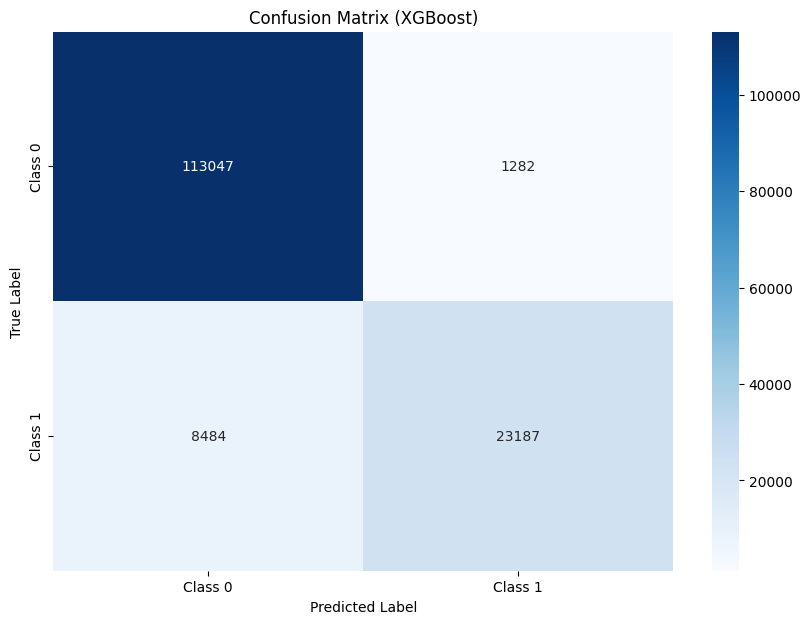

Classification Report (XGBoost):
               precision    recall  f1-score   support

     Class 0       0.93      0.99      0.96    114329
     Class 1       0.95      0.73      0.83     31671

    accuracy                           0.93    146000
   macro avg       0.94      0.86      0.89    146000
weighted avg       0.93      0.93      0.93    146000



In [20]:
# Predict on the test set
y_pred_xgb = xgb_clf.predict(X_test)

# Calculate accuracy
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f'Accuracy: {accuracy_xgb:.2f}')

# Compute confusion matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)

# Extract True Positives, False Positives, True Negatives, and False Negatives
tn, fp, fn, tp = cm_xgb.ravel()

# Calculate rates
true_positive_rate = tp / (tp + fn)
true_negative_rate = tn / (tn + fp)
false_positive_rate = fp / (fp + tn)

# F1-score
f1 = f1_score(y_test, y_pred_xgb)

# Average Precision
average_precision = average_precision_score(y_test, y_pred_xgb)

# Convert rates to percentages
true_positive_rate_pct = true_positive_rate * 100
true_negative_rate_pct = true_negative_rate * 100
false_positive_rate_pct = false_positive_rate * 100

# Output the results
print(f'True Positive Rate (Recall): {true_positive_rate_pct:.2f}%')
print(f'True Negative Rate: {true_negative_rate_pct:.2f}%')
print(f'False Positive Rate: {false_positive_rate_pct:.2f}%')
print(f'F1-Score: {f1:.4f}')
print(f'Average Precision: {average_precision:.4f}')

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Class 0', 'Class 1'], 
            yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (XGBoost)')
plt.show()

# Classification report including precision, recall, and f1-score
report_xgb = classification_report(y_test, y_pred_xgb, target_names=['Class 0', 'Class 1'])
print('Classification Report (XGBoost):\n', report_xgb)

# Neuro-fuzzy systems

## Implementation of Pytsk package

In [10]:
# split data (i am using numpy here from now on since it is compatible with pytsk)
X = df_scaled.drop(columns=['Label']).to_numpy()  # Drop the 'Label' column and convert to NumPy array
y = df_scaled['Label'].to_numpy()  # Convert the 'Label' column to a NumPy array


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)



## Pytsk-0 order

In [11]:
%%time
# now we start modelling
# Define TSK model parameters
n_rule = 15  # Number of rules
lr = 0.1  # Learning rate
weight_decay = 1e-8
order = 0

# Define antecedent
init_center = antecedent_init_center(X_train_resampled, y_train_resampled, n_rule=n_rule)
gmf = nn.Sequential(
    AntecedentGMF(in_dim=X_train_resampled.shape[1], n_rule=n_rule, high_dim=False, init_center=init_center),
    nn.Dropout(p=0.25),
    nn.LayerNorm(n_rule),
    nn.ReLU()
)

# Define full TSK model
model = TSK(in_dim=X_train_resampled.shape[1], out_dim=len(np.unique(y)), n_rule=n_rule, antecedent=gmf, order=order, precons=nn.BatchNorm1d(X_train_resampled.shape[1]))

# Define optimizer
ante_param, other_param = [], []
for n, p in model.named_parameters():
    if "center" in n or "sigma" in n:
        ante_param.append(p)
    else:
        other_param.append(p)
optimizer = AdamW(
    [{'params': ante_param, "weight_decay": 0},
     {'params': other_param, "weight_decay": weight_decay}],
    lr=lr
)

# Split training data into training and validation sets
X_train_resampled, X_val, y_train_resampled, y_val = train_test_split(X_train_resampled, y_train_resampled, test_size=0.1, random_state=42)

# Define early stopping callback
EACC = EarlyStoppingACC(X_val, y_val, verbose=1, patience=200, save_path="Pytsk-0.pkl")

# Train TSK model
ur = 1.0
ur_tau = 0.5
wrapper = Wrapper(model, optimizer=optimizer, criterion=nn.CrossEntropyLoss(),
                  epochs=100, callbacks=[EACC], ur=ur, ur_tau=ur_tau)
wrapper.fit(X_train_resampled, y_train_resampled)


[Epoch     0] EarlyStopping Callback ACC: 0.8458, Best ACC: 0.8458
[Epoch     1] EarlyStopping Callback ACC: 0.8472, Best ACC: 0.8472
[Epoch     2] EarlyStopping Callback ACC: 0.8454, Best ACC: 0.8472
[Epoch     3] EarlyStopping Callback ACC: 0.8364, Best ACC: 0.8472
[Epoch     4] EarlyStopping Callback ACC: 0.8469, Best ACC: 0.8472
[Epoch     5] EarlyStopping Callback ACC: 0.8461, Best ACC: 0.8472
[Epoch     6] EarlyStopping Callback ACC: 0.8471, Best ACC: 0.8472
[Epoch     7] EarlyStopping Callback ACC: 0.8425, Best ACC: 0.8472
[Epoch     8] EarlyStopping Callback ACC: 0.8433, Best ACC: 0.8472
[Epoch     9] EarlyStopping Callback ACC: 0.8464, Best ACC: 0.8472
[Epoch    10] EarlyStopping Callback ACC: 0.8325, Best ACC: 0.8472
[Epoch    11] EarlyStopping Callback ACC: 0.8423, Best ACC: 0.8472
[Epoch    12] EarlyStopping Callback ACC: 0.8469, Best ACC: 0.8472
[Epoch    13] EarlyStopping Callback ACC: 0.8470, Best ACC: 0.8472
[Epoch    14] EarlyStopping Callback ACC: 0.8440, Best ACC: 0.

C:\Users\qaboshama\AppData\Local\miniconda3\Lib\site-packages\pytsk\gradient_descent\training.py:266: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dic

[TSK] ACC: 0.9250

Classification Report:
               precision    recall  f1-score   support

   Class 0.0       0.93      0.98      0.95    114329
   Class 1.0       0.92      0.71      0.80     31671

    accuracy                           0.92    146000
   macro avg       0.92      0.85      0.88    146000
weighted avg       0.92      0.92      0.92    146000

True Positive Rate (Recall): 0.7132
True Negative Rate: 0.9836
False Positive Rate: 0.0164
F1-Score: 0.8048
Average Precision: 0.7208


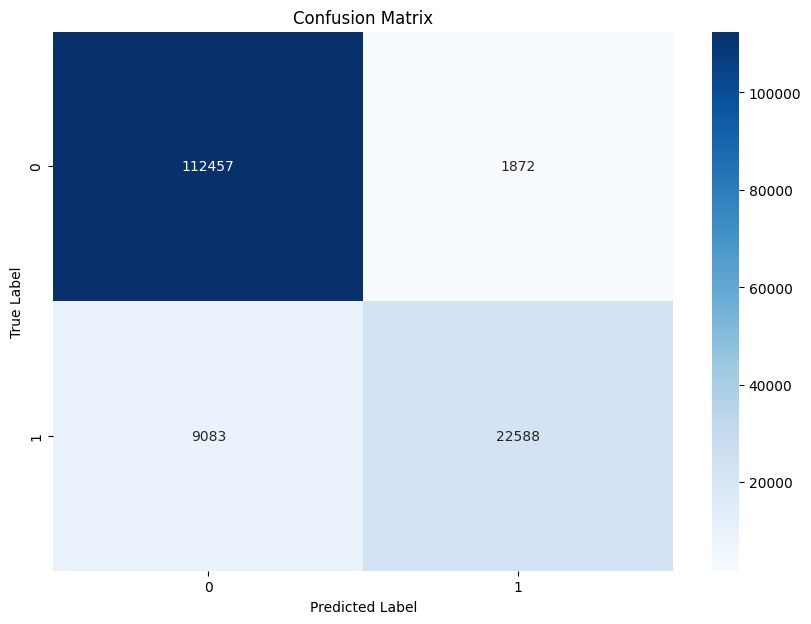

In [12]:

# Load the best saved model
wrapper.load("Pytsk-0.pkl")

# Predict and evaluate on the test set
y_prob = wrapper.predict(X_test)
y_pred = y_prob.argmax(axis=1)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("[TSK] ACC: {:.4f}".format(accuracy))

# Classification Report (includes Precision, Recall, and F1-score)
report = classification_report(y_test, y_pred, target_names=[f'Class {i}' for i in np.unique(y)])
print("\nClassification Report:\n", report)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Extracting True Positives, False Positives, True Negatives, and False Negatives
tn, fp, fn, tp = cm.ravel()

# True Positive Rate (Recall) = TP / (TP + FN)
true_positive_rate = tp / (tp + fn)

# True Negative Rate = TN / (TN + FP)
true_negative_rate = tn / (tn + fp)

# False Positive Rate = FP / (FP + TN)
false_positive_rate = fp / (fp + tn)

# F1-score (already part of the classification report, but computed here explicitly)
f1 = f1_score(y_test, y_pred)

# Average Precision
average_precision = average_precision_score(y_test, y_pred)

# Output the results
print(f"True Positive Rate (Recall): {true_positive_rate:.4f}")
print(f"True Negative Rate: {true_negative_rate:.4f}")
print(f"False Positive Rate: {false_positive_rate:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Average Precision: {average_precision:.4f}")

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.arange(cm.shape[1]), 
            yticklabels=np.arange(cm.shape[0]))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


 ## Pytsk-1st order

In [13]:
%%time
# now we start modelling
# Define TSK model parameters
n_rule = 15  # Number of rules
lr = 0.1  # Learning rate
weight_decay = 1e-8
order = 1

# Define antecedent
init_center = antecedent_init_center(X_train_resampled, y_train_resampled, n_rule=n_rule)
gmf = nn.Sequential(
    AntecedentGMF(in_dim=X_train_resampled.shape[1], n_rule=n_rule, high_dim=False, init_center=init_center),
    nn.Dropout(p=0.25),
    nn.LayerNorm(n_rule),
    nn.ReLU()
)

# Define full TSK model
model = TSK(in_dim=X_train_resampled.shape[1], out_dim=len(np.unique(y)), n_rule=n_rule, antecedent=gmf, order=order, precons=nn.BatchNorm1d(X_train_resampled.shape[1]))

# Define optimizer
ante_param, other_param = [], []
for n, p in model.named_parameters():
    if "center" in n or "sigma" in n:
        ante_param.append(p)
    else:
        other_param.append(p)
optimizer = AdamW(
    [{'params': ante_param, "weight_decay": 0},
     {'params': other_param, "weight_decay": weight_decay}],
    lr=lr
)

# Split training data into training and validation sets
X_train_resampled, X_val, y_train_resampled, y_val = train_test_split(X_train_resampled, y_train_resampled, test_size=0.1, random_state=42)

# Define early stopping callback
EACC = EarlyStoppingACC(X_val, y_val, verbose=1, patience=200, save_path="Pytsk-1.pkl")

# Train TSK model
ur = 1.0
ur_tau = 0.5
wrapper = Wrapper(model, optimizer=optimizer, criterion=nn.CrossEntropyLoss(),
                  epochs=100, callbacks=[EACC], ur=ur, ur_tau=ur_tau)
wrapper.fit(X_train_resampled, y_train_resampled)


[Epoch     0] EarlyStopping Callback ACC: 0.8467, Best ACC: 0.8467
[Epoch     1] EarlyStopping Callback ACC: 0.8459, Best ACC: 0.8467
[Epoch     2] EarlyStopping Callback ACC: 0.8471, Best ACC: 0.8471
[Epoch     3] EarlyStopping Callback ACC: 0.8415, Best ACC: 0.8471
[Epoch     4] EarlyStopping Callback ACC: 0.8438, Best ACC: 0.8471
[Epoch     5] EarlyStopping Callback ACC: 0.8472, Best ACC: 0.8472
[Epoch     6] EarlyStopping Callback ACC: 0.8463, Best ACC: 0.8472
[Epoch     7] EarlyStopping Callback ACC: 0.8473, Best ACC: 0.8473
[Epoch     8] EarlyStopping Callback ACC: 0.8474, Best ACC: 0.8474
[Epoch     9] EarlyStopping Callback ACC: 0.8472, Best ACC: 0.8474
[Epoch    10] EarlyStopping Callback ACC: 0.8462, Best ACC: 0.8474
[Epoch    11] EarlyStopping Callback ACC: 0.8464, Best ACC: 0.8474
[Epoch    12] EarlyStopping Callback ACC: 0.8360, Best ACC: 0.8474
[Epoch    13] EarlyStopping Callback ACC: 0.8472, Best ACC: 0.8474
[Epoch    14] EarlyStopping Callback ACC: 0.8463, Best ACC: 0.

C:\Users\qaboshama\AppData\Local\miniconda3\Lib\site-packages\pytsk\gradient_descent\training.py:266: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dic

[TSK] ACC: 0.9261

Classification Report:
               precision    recall  f1-score   support

   Class 0.0       0.92      0.99      0.95    114329
   Class 1.0       0.93      0.71      0.81     31671

    accuracy                           0.93    146000
   macro avg       0.93      0.85      0.88    146000
weighted avg       0.93      0.93      0.92    146000

True Positive Rate (Recall): 0.7103
True Negative Rate: 0.9859
False Positive Rate: 0.0141
F1-Score: 0.8067
Average Precision: 0.7257


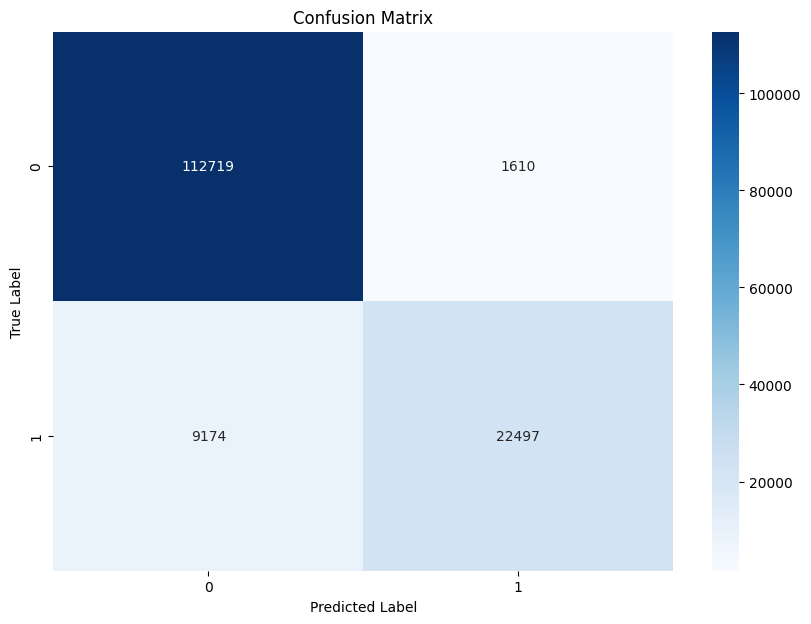

In [14]:

# Load the best saved model
wrapper.load("Pytsk-1.pkl")

# Predict and evaluate on the test set
y_prob = wrapper.predict(X_test)
y_pred = y_prob.argmax(axis=1)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("[TSK] ACC: {:.4f}".format(accuracy))

# Classification Report (includes Precision, Recall, and F1-score)
report = classification_report(y_test, y_pred, target_names=[f'Class {i}' for i in np.unique(y)])
print("\nClassification Report:\n", report)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Extracting True Positives, False Positives, True Negatives, and False Negatives
tn, fp, fn, tp = cm.ravel()

# True Positive Rate (Recall) = TP / (TP + FN)
true_positive_rate = tp / (tp + fn)

# True Negative Rate = TN / (TN + FP)
true_negative_rate = tn / (tn + fp)

# False Positive Rate = FP / (FP + TN)
false_positive_rate = fp / (fp + tn)

# F1-score (already part of the classification report, but computed here explicitly)
f1 = f1_score(y_test, y_pred)

# Average Precision
average_precision = average_precision_score(y_test, y_pred)

# Output the results
print(f"True Positive Rate (Recall): {true_positive_rate:.4f}")
print(f"True Negative Rate: {true_negative_rate:.4f}")
print(f"False Positive Rate: {false_positive_rate:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Average Precision: {average_precision:.4f}")

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.arange(cm.shape[1]), 
            yticklabels=np.arange(cm.shape[0]))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


# Experimenting with different ANFIS implementations

## ANFIS-1st order

In [31]:
%%time
# this was a fixed learning rate please ignore


class ANFIS:
    def __init__(self, n_clusters, n_features, n_classes, X_train):
        self.n_clusters = n_clusters
        self.n_features = n_features
        self.n_classes = n_classes
        # Initialize cluster centers using KMeans
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans.fit(X_train)
        self.cluster_centers_ = kmeans.cluster_centers_
        self.std_devs_ = np.ones(n_clusters)
        self.ridge_classifier = RidgeClassifier(alpha=0.001, solver = 'lsqr')

    def _fuzzyfication(self, X):
        u = np.zeros((X.shape[0], self.n_clusters))
        for i in range(self.n_clusters):
            u[:, i] = np.exp(-np.sum((X - self.cluster_centers_[i])**2, axis=1) / (2 * self.std_devs_[i]**2))
        return u / np.sum(u, axis=1, keepdims=True)

    def fit(self, X_train, y_train, X_val, y_val, epochs=100, learning_rate=0.001, patience=20):
        best_val_accuracy = 0
        epochs_since_last_improvement = 0

        for epoch in range(epochs):
            u_train = self._fuzzyfication(X_train)
            self.ridge_classifier.fit(u_train, y_train)
            y_pred_train = self.ridge_classifier.predict(u_train)
            training_accuracy = accuracy_score(y_train, y_pred_train)

            # Calculate validation accuracy
            u_val = self._fuzzyfication(X_val)
            y_pred_val = self.ridge_classifier.predict(u_val)
            validation_accuracy = accuracy_score(y_val, y_pred_val)

            for r in range(self.n_clusters):
                error = y_train - y_pred_train
                for i in range(len(X_train)):
                    grad = error[i] * u_train[i, r] * (1 - u_train[i, r]) * (X_train[i] - self.cluster_centers_[r])
                    self.cluster_centers_[r] += learning_rate * grad

                self.std_devs_[r] += learning_rate * np.mean((X_train - self.cluster_centers_[r])**2)

            print(f'Epoch {epoch + 1}/{epochs}, Training Accuracy: {training_accuracy:.4f}, '
                  f'Validation Accuracy: {validation_accuracy:.4f}, Best Validation Accuracy: {best_val_accuracy:.4f}', flush=True)

            # Early stopping check
            if validation_accuracy > best_val_accuracy:
                best_val_accuracy = validation_accuracy
                epochs_since_last_improvement = 0
            else:
                epochs_since_last_improvement += 1

            if epochs_since_last_improvement >= patience:
                print(f'Early stopping triggered after {epoch + 1} epochs with best validation accuracy: {best_val_accuracy:.4f}')
                break

        self.print_rule_base()

    def print_rule_base(self):
        print("\nTuned Rule Base:")
        coefficients = self.ridge_classifier.coef_
        intercept = self.ridge_classifier.intercept_

        for i in range(self.n_clusters):
            rule = f"If "
            for j in range(self.n_features):
                mean = self.cluster_centers_[i][j]
                std_dev = self.std_devs_[i]
                rule += f"X{j+1} is ({mean:.3f}, {std_dev:.3f}) "
                if j < self.n_features - 1:
                    rule += "and "
            rule += f"then y = "

            cluster_coef = coefficients[i % len(coefficients)]
            cluster_intercept = intercept[i % len(intercept)]

            for j in range(self.n_features):
                rule += f"{cluster_coef[j]:.2f} * X{j+1}"
                if j < self.n_features - 1:
                    rule += " + "
            rule += f" + {cluster_intercept:.2f}"
            print(rule)

    def test(self, X_test, y_test):
        u_test = self._fuzzyfication(X_test)
        y_pred_test = self.ridge_classifier.predict(u_test)
        test_accuracy = accuracy_score(y_test, y_pred_test)
        print(f'Test Accuracy: {test_accuracy:.4f}', flush=True)

        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred_test)
        print("\nConfusion Matrix:\n", cm)

        # Classification Report
        report = classification_report(y_test, y_pred_test, zero_division=0)
        print("\nClassification Report:\n", report)

        # Calculate additional metrics
        true_positive = recall_score(y_test, y_pred_test, average='macro')
        true_negative = cm.sum() - cm.sum(axis=1).sum() + cm.diagonal().sum()
        f1 = f1_score(y_test, y_pred_test, average='macro')
        average_precision = precision_score(y_test, y_pred_test, average='macro')
        
        # Extract values from confusion matrix
        FP = cm.sum(axis=0) - np.diag(cm)  # False positives
        TN = cm.sum() - (cm.sum(axis=1) + FP)  # True negatives
        FPR = FP / (FP + TN)
        average_fpr = np.mean(FPR)  # Average false positive rate across classes

        print(f"Accuracy: {test_accuracy:.2f}")
        print(f"True Positive Rate (Recall): {true_positive * 100:.2f}%")
        print(f"True Negative Rate: {true_negative / len(y_test) * 100:.2f}%")
        print(f"F1-Score: {f1:.4f}")
        print(f"Average Precision: {average_precision:.4f}")
        print(f"Average False Positive Rate (FPR): {average_fpr:.4f}")

    def save_model(self, filename):
        with open(filename, 'wb') as file:
            pickle.dump(self, file)
        print(f'Model saved to {filename}')


# Example usage
n_clusters = 15  # Number of clusters
n_features = X.shape[1]
n_classes = len(np.unique(y))

# Split training data into training and validation sets
X_train_resampled, X_val, y_train_resampled, y_val = train_test_split(X_train_resampled, y_train_resampled, test_size=0.1, random_state=42)

# Fit the model with the resampled training data
model = ANFIS(n_clusters=n_clusters, n_features=X_train_resampled.shape[1], n_classes=n_classes, X_train=X_train_resampled)
model.fit(X_train_resampled, y_train_resampled, X_val, y_val, epochs=100, learning_rate=0.0001, patience=200)

# Test the model with the original test data
model.test(X_test, y_test)

# Save the trained model
model.save_model('tmp_08.pkl')


Epoch 1/100, Training Accuracy: 0.8452, Validation Accuracy: 0.8444, Best Validation Accuracy: 0.0000
Epoch 2/100, Training Accuracy: 0.8450, Validation Accuracy: 0.8441, Best Validation Accuracy: 0.8444
Epoch 3/100, Training Accuracy: 0.8461, Validation Accuracy: 0.8453, Best Validation Accuracy: 0.8444
Epoch 4/100, Training Accuracy: 0.8463, Validation Accuracy: 0.8454, Best Validation Accuracy: 0.8453
Epoch 5/100, Training Accuracy: 0.8465, Validation Accuracy: 0.8455, Best Validation Accuracy: 0.8454
Epoch 6/100, Training Accuracy: 0.8459, Validation Accuracy: 0.8453, Best Validation Accuracy: 0.8455
Epoch 7/100, Training Accuracy: 0.8152, Validation Accuracy: 0.8143, Best Validation Accuracy: 0.8455
Epoch 8/100, Training Accuracy: 0.8147, Validation Accuracy: 0.8138, Best Validation Accuracy: 0.8455
Epoch 9/100, Training Accuracy: 0.8190, Validation Accuracy: 0.8181, Best Validation Accuracy: 0.8455
Epoch 10/100, Training Accuracy: 0.8245, Validation Accuracy: 0.8238, Best Validat

## ANFIS-1ST-lr0.01

In [37]:
%%time


class ANFIS:
    def __init__(self, n_clusters, n_features, n_classes, X_train):
        self.n_clusters = n_clusters
        self.n_features = n_features
        self.n_classes = n_classes
        # Initialize cluster centers using KMeans
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans.fit(X_train)
        self.cluster_centers_ = kmeans.cluster_centers_
        self.std_devs_ = np.ones(n_clusters)
        self.ridge_classifier = RidgeClassifier(alpha=0.0, solver = 'lsqr')

    def _fuzzyfication(self, X):
        u = np.zeros((X.shape[0], self.n_clusters))
        for i in range(self.n_clusters):
            u[:, i] = np.exp(-np.sum((X - self.cluster_centers_[i])**2, axis=1) / (2 * self.std_devs_[i]**2))
        return u / np.sum(u, axis=1, keepdims=True)

    def fit(self, X_train, y_train, X_val, y_val, epochs=100, learning_rate=0.001, patience=20):
        best_val_accuracy = 0
        epochs_since_last_improvement = 0

        for epoch in range(epochs):
            u_train = self._fuzzyfication(X_train)
            self.ridge_classifier.fit(u_train, y_train)
            y_pred_train = self.ridge_classifier.predict(u_train)
            training_accuracy = accuracy_score(y_train, y_pred_train)

            # Calculate validation accuracy
            u_val = self._fuzzyfication(X_val)
            y_pred_val = self.ridge_classifier.predict(u_val)
            validation_accuracy = accuracy_score(y_val, y_pred_val)

            for r in range(self.n_clusters):
                error = y_train - y_pred_train
                for i in range(len(X_train)):
                    grad = error[i] * u_train[i, r] * (1 - u_train[i, r]) * (X_train[i] - self.cluster_centers_[r])
                    self.cluster_centers_[r] += learning_rate * grad

                self.std_devs_[r] += learning_rate * np.mean((X_train - self.cluster_centers_[r])**2)

            print(f'Epoch {epoch + 1}/{epochs}, Training Accuracy: {training_accuracy:.4f}, '
                  f'Validation Accuracy: {validation_accuracy:.4f}, Best Validation Accuracy: {best_val_accuracy:.4f}', flush=True)

            # Early stopping check
            if validation_accuracy > best_val_accuracy:
                best_val_accuracy = validation_accuracy
                epochs_since_last_improvement = 0
            else:
                epochs_since_last_improvement += 1

            if epochs_since_last_improvement >= patience:
                print(f'Early stopping triggered after {epoch + 1} epochs with best validation accuracy: {best_val_accuracy:.4f}')
                break

        self.print_rule_base()

    def print_rule_base(self):
        print("\nTuned Rule Base:")
        coefficients = self.ridge_classifier.coef_
        intercept = self.ridge_classifier.intercept_

        for i in range(self.n_clusters):
            rule = f"If "
            for j in range(self.n_features):
                mean = self.cluster_centers_[i][j]
                std_dev = self.std_devs_[i]
                rule += f"X{j+1} is ({mean:.3f}, {std_dev:.3f}) "
                if j < self.n_features - 1:
                    rule += "and "
            rule += f"then y = "

            cluster_coef = coefficients[i % len(coefficients)]
            cluster_intercept = intercept[i % len(intercept)]

            for j in range(self.n_features):
                rule += f"{cluster_coef[j]:.2f} * X{j+1}"
                if j < self.n_features - 1:
                    rule += " + "
            rule += f" + {cluster_intercept:.2f}"
            print(rule)

    def test(self, X_test, y_test):
        u_test = self._fuzzyfication(X_test)
        y_pred_test = self.ridge_classifier.predict(u_test)
        test_accuracy = accuracy_score(y_test, y_pred_test)
        print(f'Test Accuracy: {test_accuracy:.4f}', flush=True)

        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred_test)
        print("\nConfusion Matrix:\n", cm)

        # Classification Report
        report = classification_report(y_test, y_pred_test, zero_division=0)
        print("\nClassification Report:\n", report)

        # Calculate additional metrics
        true_positive = recall_score(y_test, y_pred_test, average='macro')
        true_negative = cm.sum() - cm.sum(axis=1).sum() + cm.diagonal().sum()
        f1 = f1_score(y_test, y_pred_test, average='macro')
        average_precision = precision_score(y_test, y_pred_test, average='macro')
        
        # Extract values from confusion matrix
        FP = cm.sum(axis=0) - np.diag(cm)  # False positives
        TN = cm.sum() - (cm.sum(axis=1) + FP)  # True negatives
        FPR = FP / (FP + TN)
        average_fpr = np.mean(FPR)  # Average false positive rate across classes

        print(f"Accuracy: {test_accuracy:.2f}")
        print(f"True Positive Rate (Recall): {true_positive * 100:.2f}%")
        print(f"True Negative Rate: {true_negative / len(y_test) * 100:.2f}%")
        print(f"F1-Score: {f1:.4f}")
        print(f"Average Precision: {average_precision:.4f}")
        print(f"Average False Positive Rate (FPR): {average_fpr:.4f}")

    def save_model(self, filename):
        with open(filename, 'wb') as file:
            pickle.dump(self, file)
        print(f'Model saved to {filename}')


# Example usage
n_clusters = 15  # Number of clusters
n_features = X.shape[1]
n_classes = len(np.unique(y))

# Split training data into training and validation sets
X_train_resampled, X_val, y_train_resampled, y_val = train_test_split(X_train_resampled, y_train_resampled, test_size=0.1, random_state=42)

# Fit the model with the resampled training data
model = ANFIS(n_clusters=n_clusters, n_features=X_train_resampled.shape[1], n_classes=n_classes, X_train=X_train_resampled)
model.fit(X_train_resampled, y_train_resampled, X_val, y_val, epochs=100, learning_rate=0.01, patience=200)

# Test the model with the original test data
model.test(X_test, y_test)

# Save the trained model
model.save_model('tmp_08.pkl')


Epoch 1/100, Training Accuracy: 0.8445, Validation Accuracy: 0.8394, Best Validation Accuracy: 0.0000
Epoch 2/100, Training Accuracy: 0.8444, Validation Accuracy: 0.8396, Best Validation Accuracy: 0.8394
Epoch 3/100, Training Accuracy: 0.8446, Validation Accuracy: 0.8398, Best Validation Accuracy: 0.8396
Epoch 4/100, Training Accuracy: 0.8340, Validation Accuracy: 0.8306, Best Validation Accuracy: 0.8398
Epoch 5/100, Training Accuracy: 0.8280, Validation Accuracy: 0.8251, Best Validation Accuracy: 0.8398
Epoch 6/100, Training Accuracy: 0.8259, Validation Accuracy: 0.8226, Best Validation Accuracy: 0.8398
Epoch 7/100, Training Accuracy: 0.8242, Validation Accuracy: 0.8208, Best Validation Accuracy: 0.8398
Epoch 8/100, Training Accuracy: 0.8222, Validation Accuracy: 0.8192, Best Validation Accuracy: 0.8398
Epoch 9/100, Training Accuracy: 0.8209, Validation Accuracy: 0.8181, Best Validation Accuracy: 0.8398
Epoch 10/100, Training Accuracy: 0.8201, Validation Accuracy: 0.8171, Best Validat

## ANFIS-0 order

lr = 0.0001

In [32]:
%%time

class ZeroOrderANFIS:
    def __init__(self, n_clusters, n_features, n_classes, X_train):
        self.n_clusters = n_clusters
        self.n_features = n_features
        self.n_classes = n_classes
        
        # Initialize cluster centers using KMeans
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans.fit(X_train)
        self.cluster_centers_ = kmeans.cluster_centers_
        self.std_devs_ = np.ones(n_clusters)
        self.ridge_classifier = RidgeClassifier(alpha=0.01, solver='lsqr')

    def _fuzzyfication(self, X):
        u = np.zeros((X.shape[0], self.n_clusters))
        for i in range(self.n_clusters):
            u[:, i] = np.exp(-np.sum((X - self.cluster_centers_[i])**2, axis=1) / (2 * self.std_devs_[i]**2))
        return u / np.sum(u, axis=1, keepdims=True)

    def fit(self, X_train, y_train, X_val, y_val, epochs=100, learning_rate=0.01, patience=20):
        best_val_accuracy = 0
        epochs_since_last_improvement = 0

        for epoch in range(epochs):
            u_train = self._fuzzyfication(X_train)
            self.ridge_classifier.fit(u_train, y_train)
            y_pred_train = self.ridge_classifier.predict(u_train)
            training_accuracy = accuracy_score(y_train, y_pred_train)

            # Calculate validation accuracy
            u_val = self._fuzzyfication(X_val)
            y_pred_val = self.ridge_classifier.predict(u_val)
            validation_accuracy = accuracy_score(y_val, y_pred_val)

            for r in range(self.n_clusters):
                error = y_train - y_pred_train
                for i in range(len(X_train)):
                    grad = error[i] * u_train[i, r] * (1 - u_train[i, r]) * (X_train[i] - self.cluster_centers_[r])
                    self.cluster_centers_[r] += learning_rate * grad

                self.std_devs_[r] += learning_rate * np.mean((X_train - self.cluster_centers_[r])**2)

            print(f'Epoch {epoch + 1}/{epochs}, Training Accuracy: {training_accuracy:.4f}, '
                  f'Validation Accuracy: {validation_accuracy:.4f}, Best Validation Accuracy: {best_val_accuracy:.4f}', flush=True)

            # Early stopping check
            if validation_accuracy > best_val_accuracy:
                best_val_accuracy = validation_accuracy
                epochs_since_last_improvement = 0
            else:
                epochs_since_last_improvement += 1

            if epochs_since_last_improvement >= patience:
                print(f'Early stopping triggered after {epoch + 1} epochs with best validation accuracy: {best_val_accuracy:.4f}')
                break

        self.print_rule_base()

    def print_rule_base(self):
        print("\nTuned Rule Base:")
        intercept = self.ridge_classifier.intercept_

        for i in range(self.n_clusters):
            rule = f"If "
            for j in range(self.n_features):
                mean = self.cluster_centers_[i][j]
                std_dev = self.std_devs_[i]
                rule += f"X{j+1} is ({mean:.3f}, {std_dev:.3f}) "
                if j < self.n_features - 1:
                    rule += "and "
            rule += f"then y = {intercept[i % len(intercept)]:.2f}"  # Use only intercept (Zero-order)
            print(rule)

    def test(self, X_test, y_test):
        u_test = self._fuzzyfication(X_test)
        y_pred_test = self.ridge_classifier.predict(u_test)
        test_accuracy = accuracy_score(y_test, y_pred_test)
        print(f'Test Accuracy: {test_accuracy:.4f}', flush=True)

        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred_test)
        print("\nConfusion Matrix:\n", cm)

        # Classification Report
        report = classification_report(y_test, y_pred_test, zero_division=0)
        print("\nClassification Report:\n", report)

        # Calculate additional metrics
        true_positive = recall_score(y_test, y_pred_test, average='macro')
        true_negative = cm.sum() - cm.sum(axis=1).sum() + cm.diagonal().sum()
        f1 = f1_score(y_test, y_pred_test, average='macro')
        average_precision = precision_score(y_test, y_pred_test, average='macro')

        print(f"Accuracy: {test_accuracy:.2f}")
        print(f"True Positive Rate (Recall): {true_positive * 100:.2f}%")
        print(f"True Negative Rate: {true_negative / len(y_test) * 100:.2f}%")
        print(f"F1-Score: {f1:.4f}")
        print(f"Average Precision: {average_precision:.4f}")

    def save_model(self, filename):
        with open(filename, 'wb') as file:
            pickle.dump(self, file)
        print(f'Model saved to {filename}')

# Assuming you have your resampled training data and test data ready
# n_clusters, n_features, and n_classes should be set according to your data

n_clusters = 15  # Number of clusters
n_features = X_train_resampled.shape[1]  # Use the number of features from your training data
n_classes = len(np.unique(y_train_resampled))  # Number of classes in your target variable

# Split training data into training and validation sets
X_train_resampled, X_val, y_train_resampled, y_val = train_test_split(X_train_resampled, y_train_resampled, test_size=0.1, random_state=42)

# Create and train the zero-order ANFIS model
model = ZeroOrderANFIS(n_clusters=n_clusters, n_features=n_features, n_classes=n_classes, X_train=X_train_resampled)
model.fit(X_train_resampled, y_train_resampled, X_val, y_val, epochs=100, learning_rate=0.0001, patience=200)

# Test the model with the original test data
model.test(X_test, y_test)

# Save the trained model
model.save_model('tmp_09.pkl')


Epoch 1/100, Training Accuracy: 0.8446, Validation Accuracy: 0.8449, Best Validation Accuracy: 0.0000
Epoch 2/100, Training Accuracy: 0.8452, Validation Accuracy: 0.8456, Best Validation Accuracy: 0.8449
Epoch 3/100, Training Accuracy: 0.8451, Validation Accuracy: 0.8454, Best Validation Accuracy: 0.8456
Epoch 4/100, Training Accuracy: 0.8459, Validation Accuracy: 0.8466, Best Validation Accuracy: 0.8456
Epoch 5/100, Training Accuracy: 0.8463, Validation Accuracy: 0.8469, Best Validation Accuracy: 0.8466
Epoch 6/100, Training Accuracy: 0.8464, Validation Accuracy: 0.8470, Best Validation Accuracy: 0.8469
Epoch 7/100, Training Accuracy: 0.8464, Validation Accuracy: 0.8471, Best Validation Accuracy: 0.8470
Epoch 8/100, Training Accuracy: 0.8306, Validation Accuracy: 0.8313, Best Validation Accuracy: 0.8471
Epoch 9/100, Training Accuracy: 0.8084, Validation Accuracy: 0.8092, Best Validation Accuracy: 0.8471
Epoch 10/100, Training Accuracy: 0.8082, Validation Accuracy: 0.8091, Best Validat

lr = 0.01

In [36]:
%%time

class ZeroOrderANFIS:
    def __init__(self, n_clusters, n_features, n_classes, X_train):
        self.n_clusters = n_clusters
        self.n_features = n_features
        self.n_classes = n_classes
        
        # Initialize cluster centers using KMeans
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans.fit(X_train)
        self.cluster_centers_ = kmeans.cluster_centers_
        self.std_devs_ = np.ones(n_clusters)
        self.ridge_classifier = RidgeClassifier(alpha=0.0, solver='lsqr')

    def _fuzzyfication(self, X):
        u = np.zeros((X.shape[0], self.n_clusters))
        for i in range(self.n_clusters):
            u[:, i] = np.exp(-np.sum((X - self.cluster_centers_[i])**2, axis=1) / (2 * self.std_devs_[i]**2))
        return u / np.sum(u, axis=1, keepdims=True)

    def fit(self, X_train, y_train, X_val, y_val, epochs=100, learning_rate=0.01, patience=20):
        best_val_accuracy = 0
        epochs_since_last_improvement = 0

        for epoch in range(epochs):
            u_train = self._fuzzyfication(X_train)
            self.ridge_classifier.fit(u_train, y_train)
            y_pred_train = self.ridge_classifier.predict(u_train)
            training_accuracy = accuracy_score(y_train, y_pred_train)

            # Calculate validation accuracy
            u_val = self._fuzzyfication(X_val)
            y_pred_val = self.ridge_classifier.predict(u_val)
            validation_accuracy = accuracy_score(y_val, y_pred_val)

            for r in range(self.n_clusters):
                error = y_train - y_pred_train
                for i in range(len(X_train)):
                    grad = error[i] * u_train[i, r] * (1 - u_train[i, r]) * (X_train[i] - self.cluster_centers_[r])
                    self.cluster_centers_[r] += learning_rate * grad

                self.std_devs_[r] += learning_rate * np.mean((X_train - self.cluster_centers_[r])**2)

            print(f'Epoch {epoch + 1}/{epochs}, Training Accuracy: {training_accuracy:.4f}, '
                  f'Validation Accuracy: {validation_accuracy:.4f}, Best Validation Accuracy: {best_val_accuracy:.4f}', flush=True)

            # Early stopping check
            if validation_accuracy > best_val_accuracy:
                best_val_accuracy = validation_accuracy
                epochs_since_last_improvement = 0
            else:
                epochs_since_last_improvement += 1

            if epochs_since_last_improvement >= patience:
                print(f'Early stopping triggered after {epoch + 1} epochs with best validation accuracy: {best_val_accuracy:.4f}')
                break

        self.print_rule_base()

    def print_rule_base(self):
        print("\nTuned Rule Base:")
        intercept = self.ridge_classifier.intercept_

        for i in range(self.n_clusters):
            rule = f"If "
            for j in range(self.n_features):
                mean = self.cluster_centers_[i][j]
                std_dev = self.std_devs_[i]
                rule += f"X{j+1} is ({mean:.3f}, {std_dev:.3f}) "
                if j < self.n_features - 1:
                    rule += "and "
            rule += f"then y = {intercept[i % len(intercept)]:.2f}"  # Use only intercept (Zero-order)
            print(rule)

    def test(self, X_test, y_test):
        u_test = self._fuzzyfication(X_test)
        y_pred_test = self.ridge_classifier.predict(u_test)
        test_accuracy = accuracy_score(y_test, y_pred_test)
        print(f'Test Accuracy: {test_accuracy:.4f}', flush=True)

        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred_test)
        print("\nConfusion Matrix:\n", cm)

        # Classification Report
        report = classification_report(y_test, y_pred_test, zero_division=0)
        print("\nClassification Report:\n", report)

        # Calculate additional metrics
        true_positive = recall_score(y_test, y_pred_test, average='macro')
        true_negative = cm.sum() - cm.sum(axis=1).sum() + cm.diagonal().sum()
        f1 = f1_score(y_test, y_pred_test, average='macro')
        average_precision = precision_score(y_test, y_pred_test, average='macro')

        print(f"Accuracy: {test_accuracy:.2f}")
        print(f"True Positive Rate (Recall): {true_positive * 100:.2f}%")
        print(f"True Negative Rate: {true_negative / len(y_test) * 100:.2f}%")
        print(f"F1-Score: {f1:.4f}")
        print(f"Average Precision: {average_precision:.4f}")

    def save_model(self, filename):
        with open(filename, 'wb') as file:
            pickle.dump(self, file)
        print(f'Model saved to {filename}')

# Assuming you have your resampled training data and test data ready
# n_clusters, n_features, and n_classes should be set according to your data

n_clusters = 15  # Number of clusters
n_features = X_train_resampled.shape[1]  # Use the number of features from your training data
n_classes = len(np.unique(y_train_resampled))  # Number of classes in your target variable

# Split training data into training and validation sets
X_train_resampled, X_val, y_train_resampled, y_val = train_test_split(X_train_resampled, y_train_resampled, test_size=0.1, random_state=42)

# Create and train the zero-order ANFIS model
model = ZeroOrderANFIS(n_clusters=n_clusters, n_features=n_features, n_classes=n_classes, X_train=X_train_resampled)
model.fit(X_train_resampled, y_train_resampled, X_val, y_val, epochs=100, learning_rate=0.01, patience=200)

# Test the model with the original test data
model.test(X_test, y_test)

# Save the trained model
model.save_model('tmp_09.pkl')


Epoch 1/100, Training Accuracy: 0.8441, Validation Accuracy: 0.8445, Best Validation Accuracy: 0.0000
Epoch 2/100, Training Accuracy: 0.8438, Validation Accuracy: 0.8442, Best Validation Accuracy: 0.8445
Epoch 3/100, Training Accuracy: 0.8442, Validation Accuracy: 0.8443, Best Validation Accuracy: 0.8445
Epoch 4/100, Training Accuracy: 0.7969, Validation Accuracy: 0.7974, Best Validation Accuracy: 0.8445
Epoch 5/100, Training Accuracy: 0.8311, Validation Accuracy: 0.8312, Best Validation Accuracy: 0.8445
Epoch 6/100, Training Accuracy: 0.8458, Validation Accuracy: 0.8460, Best Validation Accuracy: 0.8445
Epoch 7/100, Training Accuracy: 0.8455, Validation Accuracy: 0.8458, Best Validation Accuracy: 0.8460
Epoch 8/100, Training Accuracy: 0.8454, Validation Accuracy: 0.8457, Best Validation Accuracy: 0.8460
Epoch 9/100, Training Accuracy: 0.8200, Validation Accuracy: 0.8198, Best Validation Accuracy: 0.8460
Epoch 10/100, Training Accuracy: 0.8145, Validation Accuracy: 0.8139, Best Validat

replacing k-means with grid partitioning in the initilization of ANFIS zero order

In [17]:
%%time

class ZeroOrderANFIS:
    def __init__(self, n_clusters, n_features, n_classes, X_train):
        self.n_clusters = n_clusters
        self.n_features = n_features
        self.n_classes = n_classes
        
        # Initialize cluster centers using grid partitioning
        self.cluster_centers_ = np.zeros((n_clusters, n_features))
        for i in range(n_features):
            feature_min = np.min(X_train[:, i])
            feature_max = np.max(X_train[:, i])
            self.cluster_centers_[:, i] = np.linspace(feature_min, feature_max, n_clusters)
        
        # Initialize standard deviations
        self.std_devs_ = np.ones(n_clusters)
        
        # Initialize RidgeClassifier
        self.ridge_classifier = RidgeClassifier(alpha=0.0, solver='lsqr')

    def _fuzzyfication(self, X):
        u = np.zeros((X.shape[0], self.n_clusters))
        for i in range(self.n_clusters):
            u[:, i] = np.exp(-np.sum((X - self.cluster_centers_[i])**2, axis=1) / (2 * self.std_devs_[i]**2))
        return u / np.sum(u, axis=1, keepdims=True)

    # The rest of the class remains unchanged


    def fit(self, X_train, y_train, X_val, y_val, epochs=100, learning_rate=0.01, patience=20):
        best_val_accuracy = 0
        epochs_since_last_improvement = 0

        for epoch in range(epochs):
            u_train = self._fuzzyfication(X_train)
            self.ridge_classifier.fit(u_train, y_train)
            y_pred_train = self.ridge_classifier.predict(u_train)
            training_accuracy = accuracy_score(y_train, y_pred_train)

            # Calculate validation accuracy
            u_val = self._fuzzyfication(X_val)
            y_pred_val = self.ridge_classifier.predict(u_val)
            validation_accuracy = accuracy_score(y_val, y_pred_val)

            for r in range(self.n_clusters):
                error = y_train - y_pred_train
                for i in range(len(X_train)):
                    grad = error[i] * u_train[i, r] * (1 - u_train[i, r]) * (X_train[i] - self.cluster_centers_[r])
                    self.cluster_centers_[r] += learning_rate * grad

                self.std_devs_[r] += learning_rate * np.mean((X_train - self.cluster_centers_[r])**2)

            print(f'Epoch {epoch + 1}/{epochs}, Training Accuracy: {training_accuracy:.4f}, '
                  f'Validation Accuracy: {validation_accuracy:.4f}, Best Validation Accuracy: {best_val_accuracy:.4f}', flush=True)

            # Early stopping check
            if validation_accuracy > best_val_accuracy:
                best_val_accuracy = validation_accuracy
                epochs_since_last_improvement = 0
            else:
                epochs_since_last_improvement += 1

            if epochs_since_last_improvement >= patience:
                print(f'Early stopping triggered after {epoch + 1} epochs with best validation accuracy: {best_val_accuracy:.4f}')
                break

        self.print_rule_base()

    def print_rule_base(self):
        print("\nTuned Rule Base:")
        intercept = self.ridge_classifier.intercept_

        for i in range(self.n_clusters):
            rule = f"If "
            for j in range(self.n_features):
                mean = self.cluster_centers_[i][j]
                std_dev = self.std_devs_[i]
                rule += f"X{j+1} is ({mean:.3f}, {std_dev:.3f}) "
                if j < self.n_features - 1:
                    rule += "and "
            rule += f"then y = {intercept[i % len(intercept)]:.2f}"  # Use only intercept (Zero-order)
            print(rule)

    def test(self, X_test, y_test):
        u_test = self._fuzzyfication(X_test)
        y_pred_test = self.ridge_classifier.predict(u_test)
        test_accuracy = accuracy_score(y_test, y_pred_test)
        print(f'Test Accuracy: {test_accuracy:.4f}', flush=True)

        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred_test)
        print("\nConfusion Matrix:\n", cm)

        # Classification Report
        report = classification_report(y_test, y_pred_test, zero_division=0)
        print("\nClassification Report:\n", report)

        # Calculate additional metrics
        true_positive = recall_score(y_test, y_pred_test, average='macro')
        true_negative = cm.sum() - cm.sum(axis=1).sum() + cm.diagonal().sum()
        f1 = f1_score(y_test, y_pred_test, average='macro')
        average_precision = precision_score(y_test, y_pred_test, average='macro')

        print(f"Accuracy: {test_accuracy:.2f}")
        print(f"True Positive Rate (Recall): {true_positive * 100:.2f}%")
        print(f"True Negative Rate: {true_negative / len(y_test) * 100:.2f}%")
        print(f"F1-Score: {f1:.4f}")
        print(f"Average Precision: {average_precision:.4f}")

    def save_model(self, filename):
        with open(filename, 'wb') as file:
            pickle.dump(self, file)
        print(f'Model saved to {filename}')

# Assuming you have your resampled training data and test data ready
# n_clusters, n_features, and n_classes should be set according to your data

n_clusters = 15  # Number of clusters
n_features = X_train_resampled.shape[1]  # Use the number of features from your training data
n_classes = 2  # Number of classes in your target variable

# Split training data into training and validation sets
X_train_resampled, X_val, y_train_resampled, y_val = train_test_split(X_train_resampled, y_train_resampled, test_size=0.1, random_state=42)

# Create and train the zero-order ANFIS model
model = ZeroOrderANFIS(n_clusters=n_clusters, n_features=n_features, n_classes=n_classes, X_train=X_train_resampled)
model.fit(X_train_resampled, y_train_resampled, X_val, y_val, epochs=2, learning_rate=0.01, patience=200)

# Test the model with the original test data
model.test(X_test, y_test)

# Save the trained model
model.save_model('tmp_09.pkl')


Epoch 1/2, Training Accuracy: 0.8441, Validation Accuracy: 0.8433, Best Validation Accuracy: 0.0000
Epoch 2/2, Training Accuracy: 0.8455, Validation Accuracy: 0.8448, Best Validation Accuracy: 0.8433

Tuned Rule Base:
If X1 is (-8.256, 1.548) and X2 is (-7.712, 1.548) and X3 is (-7.307, 1.548) and X4 is (-5.209, 1.548) and X5 is (-3.562, 1.548) and X6 is (-3.782, 1.548) and X7 is (-4.015, 1.548) and X8 is (-4.207, 1.548) and X9 is (-4.055, 1.548) and X10 is (-4.091, 1.548) then y = 0.98
If X1 is (-7.643, 1.465) and X2 is (-7.136, 1.465) and X3 is (-6.758, 1.465) and X4 is (-4.784, 1.465) and X5 is (-3.251, 1.465) and X6 is (-3.455, 1.465) and X7 is (-3.673, 1.465) and X8 is (-3.850, 1.465) and X9 is (-3.711, 1.465) and X10 is (-3.743, 1.465) then y = 0.98
If X1 is (-7.031, 1.389) and X2 is (-6.559, 1.389) and X3 is (-6.208, 1.389) and X4 is (-4.361, 1.389) and X5 is (-2.941, 1.389) and X6 is (-3.129, 1.389) and X7 is (-3.332, 1.389) and X8 is (-3.495, 1.389) and X9 is (-3.367, 1.389) a

lr = 0.01

In [33]:
%%time
class ZeroOrderANFIS:
    def __init__(self, n_clusters, n_features, n_classes, X_train):
        self.n_clusters = n_clusters
        self.n_features = n_features
        self.n_classes = n_classes
        
        # Initialize cluster centers with proper dimensions (n_clusters, n_features)
        self.cluster_centers_ = np.zeros((n_clusters, n_features))
        for i in range(n_features):
            feature_min = np.min(X_train[:, i])
            feature_max = np.max(X_train[:, i])
            self.cluster_centers_[:, i] = np.linspace(feature_min, feature_max, n_clusters)
        
        # Initialize standard deviations with proper dimensions (n_clusters, n_features)
        self.std_devs_ = np.ones((n_clusters, n_features))
        
        # Initialize intercepts randomly between 0 and 1
        self.intercepts_ = np.random.rand(n_clusters)
        
        # Initialize RidgeClassifier
        self.ridge_classifier = RidgeClassifier(alpha=0.0, solver='lsqr', tol = 0.000001)

    def _fuzzyfication(self, X):
        # Membership function calculation using Gaussian functions
        u = np.zeros((X.shape[0], self.n_clusters))
        for i in range(self.n_clusters):
            dist = np.sum((X - self.cluster_centers_[i, :])**2 / (2 * self.std_devs_[i, :]**2), axis=1)
            u[:, i] = np.exp(-dist)
        return u / np.sum(u, axis=1, keepdims=True)

    def fit(self, X_train, y_train, X_val, y_val, epochs=100, learning_rate=0.01, patience=20):
        best_val_accuracy = 0
        epochs_since_last_improvement = 0

        for epoch in range(epochs):
            u_train = self._fuzzyfication(X_train)
            self.ridge_classifier.fit(u_train, y_train)
            y_pred_train = self.ridge_classifier.predict(u_train)
            training_accuracy = accuracy_score(y_train, y_pred_train)

            # Calculate validation accuracy
            u_val = self._fuzzyfication(X_val)
            y_pred_val = self.ridge_classifier.predict(u_val)
            validation_accuracy = accuracy_score(y_val, y_pred_val)

            for r in range(self.n_clusters):
                error = y_train - y_pred_train
                for i in range(len(X_train)):
                    grad = error[i] * u_train[i, r] * (1 - u_train[i, r]) * (X_train[i] - self.cluster_centers_[r])
                    self.cluster_centers_[r] += learning_rate * grad

                # Update standard deviations for each feature
                self.std_devs_[r, :] += learning_rate * np.mean((X_train - self.cluster_centers_[r])**2, axis=0)

            print(f'Epoch {epoch + 1}/{epochs}, Training Accuracy: {training_accuracy:.4f}, '
                  f'Validation Accuracy: {validation_accuracy:.4f}, Best Validation Accuracy: {best_val_accuracy:.4f}', flush=True)

            # Early stopping check
            if validation_accuracy > best_val_accuracy:
                best_val_accuracy = validation_accuracy
                epochs_since_last_improvement = 0
            else:
                epochs_since_last_improvement += 1

            if epochs_since_last_improvement >= patience:
                print(f'Early stopping triggered after {epoch + 1} epochs with best validation accuracy: {best_val_accuracy:.4f}')
                break

        self.print_rule_base()

    def print_rule_base(self):
        print("\nTuned Rule Base:")

        for i in range(self.n_clusters):
            rule = f"If "
            for j in range(self.n_features):
                mean = self.cluster_centers_[i][j]
                std_dev = self.std_devs_[i][j]
                rule += f"X{j+1} is ({mean:.3f}, {std_dev:.3f}) "
                if j < self.n_features - 1:
                    rule += "and "
            rule += f"then y = {self.intercepts_[i]:.2f}"
            print(rule)

    # (Your existing __init__ and other methods remain unchanged)

    def test(self, X_test, y_test):
        u_test = self._fuzzyfication(X_test)
        y_pred_test = self.ridge_classifier.predict(u_test)
        test_accuracy = accuracy_score(y_test, y_pred_test)
        print(f'Test Accuracy: {test_accuracy:.4f}', flush=True)

        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred_test)
        print("\nConfusion Matrix:\n", cm)

        # Classification Report
        report = classification_report(y_test, y_pred_test, zero_division=0)
        print("\nClassification Report:\n", report)

        # Calculate additional metrics
        true_positive = recall_score(y_test, y_pred_test, average='macro')
        true_negative = cm.sum() - cm.sum(axis=1).sum() + cm.diagonal().sum()
        f1 = f1_score(y_test, y_pred_test, average='macro')
        average_precision = precision_score(y_test, y_pred_test, average='macro')

        # False Positive Rate (FPR)
        FP = cm.sum(axis=0) - np.diag(cm)
        TN = np.diag(cm)
        FPR = FP / (FP + TN)
        avg_FPR = np.mean(FPR)

        print(f"Accuracy: {test_accuracy:.2f}")
        print(f"True Positive Rate (Recall): {true_positive * 100:.2f}%")
        print(f"True Negative Rate: {true_negative / len(y_test) * 100:.2f}%")
        print(f"F1-Score: {f1:.4f}")
        print(f"Average Precision: {average_precision:.4f}")
        print(f"False Positive Rate (FPR): {avg_FPR * 100:.2f}%")
    def save_model(self, filename):
        with open(filename, 'wb') as file:
            pickle.dump(self, file)
        print(f'Model saved to {filename}')

# Assuming you have your resampled training data and test data ready
# n_clusters, n_features, and n_classes should be set according to your data

n_clusters = 15  # Number of clusters
n_features = X_train_resampled.shape[1]  # Use the number of features from your training data
n_classes = 2  # Number of classes in your target variable

# Split training data into training and validation sets
X_train_resampled, X_val, y_train_resampled, y_val = train_test_split(X_train_resampled, y_train_resampled, test_size=0.1, random_state=42)

# Create and train the zero-order ANFIS model
model = ZeroOrderANFIS(n_clusters=n_clusters, n_features=n_features, n_classes=n_classes, X_train=X_train_resampled)
model.fit(X_train_resampled, y_train_resampled, X_val, y_val, epochs=100, learning_rate=0.01, patience=200)

# Test the model with the original test data
model.test(X_test, y_test)

# Save the trained model
model.save_model('tmp_09.pkl')


Epoch 1/100, Training Accuracy: 0.8443, Validation Accuracy: 0.8412, Best Validation Accuracy: 0.0000
Epoch 2/100, Training Accuracy: 0.8449, Validation Accuracy: 0.8422, Best Validation Accuracy: 0.8412
Epoch 3/100, Training Accuracy: 0.8451, Validation Accuracy: 0.8427, Best Validation Accuracy: 0.8422
Epoch 4/100, Training Accuracy: 0.8109, Validation Accuracy: 0.8042, Best Validation Accuracy: 0.8427
Epoch 5/100, Training Accuracy: 0.8201, Validation Accuracy: 0.8138, Best Validation Accuracy: 0.8427
Epoch 6/100, Training Accuracy: 0.8245, Validation Accuracy: 0.8187, Best Validation Accuracy: 0.8427
Epoch 7/100, Training Accuracy: 0.8364, Validation Accuracy: 0.8318, Best Validation Accuracy: 0.8427
Epoch 8/100, Training Accuracy: 0.8467, Validation Accuracy: 0.8436, Best Validation Accuracy: 0.8427
Epoch 9/100, Training Accuracy: 0.8369, Validation Accuracy: 0.8316, Best Validation Accuracy: 0.8436
Epoch 10/100, Training Accuracy: 0.8257, Validation Accuracy: 0.8200, Best Validat

clipping std

In [37]:
%%time

# constrain std
class ZeroOrderANFIS:
    def __init__(self, n_clusters, n_features, n_classes, X_train):
        self.n_clusters = n_clusters
        self.n_features = n_features
        self.n_classes = n_classes
        
        # Initialize cluster centers with proper dimensions (n_clusters, n_features)
        self.cluster_centers_ = np.zeros((n_clusters, n_features))
        for i in range(n_features):
            feature_min = np.min(X_train[:, i])
            feature_max = np.max(X_train[:, i])
            self.cluster_centers_[:, i] = np.linspace(feature_min, feature_max, n_clusters)
        
        # Initialize standard deviations with proper dimensions (n_clusters, n_features)
        self.std_devs_ = np.ones((n_clusters, n_features))
        
        # Initialize intercepts randomly between 0 and 1
        self.intercepts_ = np.random.rand(n_clusters)
        
        # Initialize RidgeClassifier
        self.ridge_classifier = RidgeClassifier(alpha=0.0, solver='lsqr', tol = 0.000001)

    def _fuzzyfication(self, X):
        # Membership function calculation using Gaussian functions
        u = np.zeros((X.shape[0], self.n_clusters))
        for i in range(self.n_clusters):
            dist = np.sum((X - self.cluster_centers_[i, :])**2 / (2 * self.std_devs_[i, :]**2), axis=1)
            u[:, i] = np.exp(-dist)
        return u / np.sum(u, axis=1, keepdims=True)

    def fit(self, X_train, y_train, X_val, y_val, epochs=100, learning_rate=0.01, patience=20):
        best_val_accuracy = 0
        epochs_since_last_improvement = 0

        for epoch in range(epochs):
            u_train = self._fuzzyfication(X_train)
            self.ridge_classifier.fit(u_train, y_train)
            y_pred_train = self.ridge_classifier.predict(u_train)
            training_accuracy = accuracy_score(y_train, y_pred_train)

            # Calculate validation accuracy
            u_val = self._fuzzyfication(X_val)
            y_pred_val = self.ridge_classifier.predict(u_val)
            validation_accuracy = accuracy_score(y_val, y_pred_val)

            for r in range(self.n_clusters):
                error = y_train - y_pred_train
                for i in range(len(X_train)):
                    grad = error[i] * u_train[i, r] * (1 - u_train[i, r]) * (X_train[i] - self.cluster_centers_[r])
                    self.cluster_centers_[r] += learning_rate * grad

                # Update standard deviations for each feature
                self.std_devs_[r, :] += learning_rate * np.mean((X_train - self.cluster_centers_[r])**2, axis=0)


                # clipping
                self.std_devs_[r, :] = np.clip(self.std_devs_[r, :], 0.5, 2)


            
            print(f'Epoch {epoch + 1}/{epochs}, Training Accuracy: {training_accuracy:.4f}, '
                  f'Validation Accuracy: {validation_accuracy:.4f}, Best Validation Accuracy: {best_val_accuracy:.4f}', flush=True)

            # Early stopping check
            if validation_accuracy > best_val_accuracy:
                best_val_accuracy = validation_accuracy
                epochs_since_last_improvement = 0
            else:
                epochs_since_last_improvement += 1

            if epochs_since_last_improvement >= patience:
                print(f'Early stopping triggered after {epoch + 1} epochs with best validation accuracy: {best_val_accuracy:.4f}')
                break

        self.print_rule_base()

    def print_rule_base(self):
        print("\nTuned Rule Base:")

        for i in range(self.n_clusters):
            rule = f"If "
            for j in range(self.n_features):
                mean = self.cluster_centers_[i][j]
                std_dev = self.std_devs_[i][j]
                rule += f"X{j+1} is ({mean:.3f}, {std_dev:.3f}) "
                if j < self.n_features - 1:
                    rule += "and "
            rule += f"then y = {self.intercepts_[i]:.2f}"
            print(rule)

    # (Your existing __init__ and other methods remain unchanged)

    def test(self, X_test, y_test):
        u_test = self._fuzzyfication(X_test)
        y_pred_test = self.ridge_classifier.predict(u_test)
        test_accuracy = accuracy_score(y_test, y_pred_test)
        print(f'Test Accuracy: {test_accuracy:.4f}', flush=True)

        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred_test)
        print("\nConfusion Matrix:\n", cm)

        # Classification Report
        report = classification_report(y_test, y_pred_test, zero_division=0)
        print("\nClassification Report:\n", report)

        # Calculate additional metrics
        true_positive = recall_score(y_test, y_pred_test, average='macro')
        true_negative = cm.sum() - cm.sum(axis=1).sum() + cm.diagonal().sum()
        f1 = f1_score(y_test, y_pred_test, average='macro')
        average_precision = precision_score(y_test, y_pred_test, average='macro')

        # False Positive Rate (FPR)
        FP = cm.sum(axis=0) - np.diag(cm)
        TN = np.diag(cm)
        FPR = FP / (FP + TN)
        avg_FPR = np.mean(FPR)

        print(f"Accuracy: {test_accuracy:.2f}")
        print(f"True Positive Rate (Recall): {true_positive * 100:.2f}%")
        print(f"True Negative Rate: {true_negative / len(y_test) * 100:.2f}%")
        print(f"F1-Score: {f1:.4f}")
        print(f"Average Precision: {average_precision:.4f}")
        print(f"False Positive Rate (FPR): {avg_FPR * 100:.2f}%")
    def save_model(self, filename):
        with open(filename, 'wb') as file:
            pickle.dump(self, file)
        print(f'Model saved to {filename}')

# Assuming you have your resampled training data and test data ready
# n_clusters, n_features, and n_classes should be set according to your data

n_clusters = 15  # Number of clusters
n_features = X_train_resampled.shape[1]  # Use the number of features from your training data
n_classes = 2  # Number of classes in your target variable

# Split training data into training and validation sets
X_train_resampled, X_val, y_train_resampled, y_val = train_test_split(X_train_resampled, y_train_resampled, test_size=0.1, random_state=42)

# Create and train the zero-order ANFIS model
model = ZeroOrderANFIS(n_clusters=n_clusters, n_features=n_features, n_classes=n_classes, X_train=X_train_resampled)
model.fit(X_train_resampled, y_train_resampled, X_val, y_val, epochs=100, learning_rate=0.01, patience=200)

# Test the model with the original test data
model.test(X_test, y_test)

# Save the trained model
model.save_model('tmp_09.pkl')


Epoch 1/100, Training Accuracy: 0.8442, Validation Accuracy: 0.8423, Best Validation Accuracy: 0.0000
Epoch 2/100, Training Accuracy: 0.8468, Validation Accuracy: 0.8448, Best Validation Accuracy: 0.8423
Epoch 3/100, Training Accuracy: 0.8465, Validation Accuracy: 0.8446, Best Validation Accuracy: 0.8448
Epoch 4/100, Training Accuracy: 0.8141, Validation Accuracy: 0.8100, Best Validation Accuracy: 0.8448
Epoch 5/100, Training Accuracy: 0.8192, Validation Accuracy: 0.8152, Best Validation Accuracy: 0.8448
Epoch 6/100, Training Accuracy: 0.8213, Validation Accuracy: 0.8174, Best Validation Accuracy: 0.8448
Epoch 7/100, Training Accuracy: 0.8216, Validation Accuracy: 0.8178, Best Validation Accuracy: 0.8448
Epoch 8/100, Training Accuracy: 0.8220, Validation Accuracy: 0.8178, Best Validation Accuracy: 0.8448
Epoch 9/100, Training Accuracy: 0.8246, Validation Accuracy: 0.8207, Best Validation Accuracy: 0.8448
Epoch 10/100, Training Accuracy: 0.8441, Validation Accuracy: 0.8431, Best Validat

## fixed std (ANFIS-GP)

In [65]:
# oh year
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score
from sklearn.linear_model import RidgeClassifier
import pickle

class ZeroOrderANFIS:
    def __init__(self, n_clusters, n_features, n_classes, X_train):
        self.n_clusters = n_clusters
        self.n_features = n_features
        self.n_classes = n_classes
        
        # Initialize cluster centers
        self.cluster_centers_ = np.zeros((n_clusters, n_features))
        for i in range(n_features):
            feature_min = np.min(X_train[:, i])
            feature_max = np.max(X_train[:, i])
            self.cluster_centers_[:, i] = np.linspace(feature_min, feature_max, n_clusters)
        
        # Calculate standard deviation as range divided by (n_clusters - 1)
        self.std_devs_ = (np.max(X_train, axis=0) - np.min(X_train, axis=0)) / (n_clusters - 1)
        self.std_devs_ = np.tile(self.std_devs_, (n_clusters, 1))  # Repeat for each cluster
        
        # Initialize intercepts randomly between 0 and 1
        self.intercepts_ = np.random.rand(n_clusters)

        # Initialize RidgeClassifier
        self.ridge_classifier = RidgeClassifier(alpha=0.0, solver='lsqr', tol=0.000001)

    def _fuzzyfication(self, X):
        # Membership function calculation using Gaussian functions
        u = np.zeros((X.shape[0], self.n_clusters))
        for i in range(self.n_clusters):
            dist = np.sum((X - self.cluster_centers_[i, :])**2 / (2 * self.std_devs_[i, :]**2), axis=1)
            u[:, i] = np.exp(-dist)
        return u / np.sum(u, axis=1, keepdims=True)

    def fit(self, X_train, y_train, X_val, y_val, epochs=100, learning_rate=0.01, patience=20):
        best_val_accuracy = 0
        epochs_since_last_improvement = 0

        for epoch in range(epochs):
            u_train = self._fuzzyfication(X_train)
            self.ridge_classifier.fit(u_train, y_train)
            y_pred_train = self.ridge_classifier.predict(u_train)
            training_accuracy = accuracy_score(y_train, y_pred_train)

            # Calculate validation accuracy
            u_val = self._fuzzyfication(X_val)
            y_pred_val = self.ridge_classifier.predict(u_val)
            validation_accuracy = accuracy_score(y_val, y_pred_val)

            for r in range(self.n_clusters):
                error = y_train - y_pred_train
                for i in range(len(X_train)):
                    grad = error[i] * u_train[i, r] * (1 - u_train[i, r]) * (X_train[i] - self.cluster_centers_[r])
                    self.cluster_centers_[r] += learning_rate * grad

            print(f'Epoch {epoch + 1}/{epochs}, Training Accuracy: {training_accuracy:.4f}, '
                  f'Validation Accuracy: {validation_accuracy:.4f}, Best Validation Accuracy: {best_val_accuracy:.4f}', flush=True)

            # Early stopping check
            if validation_accuracy > best_val_accuracy:
                best_val_accuracy = validation_accuracy
                epochs_since_last_improvement = 0
            else:
                epochs_since_last_improvement += 1

            if epochs_since_last_improvement >= patience:
                print(f'Early stopping triggered after {epoch + 1} epochs with best validation accuracy: {best_val_accuracy:.4f}')
                break

        self.print_rule_base()

    def print_rule_base(self):
        print("\nTuned Rule Base:")
        for i in range(self.n_clusters):
            rule = f"If "
            for j in range(self.n_features):
                mean = self.cluster_centers_[i][j]
                std_dev = self.std_devs_[i][j]
                rule += f"X{j+1} is ({mean:.3f}, {std_dev:.3f}) "
                if j < self.n_features - 1:
                    rule += "and "
            rule += f"then y = {self.intercepts_[i]:.2f}"
            print(rule)

    def test(self, X_test, y_test):
        u_test = self._fuzzyfication(X_test)
        y_pred_test = self.ridge_classifier.predict(u_test)
        test_accuracy = accuracy_score(y_test, y_pred_test)
        print(f'Test Accuracy: {test_accuracy:.4f}', flush=True)

        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred_test)
        print("\nConfusion Matrix:\n", cm)

        # Classification Report
        report = classification_report(y_test, y_pred_test, zero_division=0)
        print("\nClassification Report:\n", report)

        # Calculate additional metrics
        true_positive = recall_score(y_test, y_pred_test, average='macro')
        true_negative = cm.sum() - cm.sum(axis=1).sum() + cm.diagonal().sum()
        f1 = f1_score(y_test, y_pred_test, average='macro')
        average_precision = precision_score(y_test, y_pred_test, average='macro')

        # False Positive Rate (FPR)
        FP = cm.sum(axis=0) - np.diag(cm)
        TN = np.diag(cm)
        FPR = FP / (FP + TN)
        avg_FPR = np.mean(FPR)

        print(f"Accuracy: {test_accuracy:.2f}")
        print(f"True Positive Rate (Recall): {true_positive * 100:.2f}%")
        print(f"True Negative Rate: {true_negative / len(y_test) * 100:.2f}%")
        print(f"F1-Score: {f1:.4f}")
        print(f"Average Precision: {average_precision:.4f}")
        print(f"False Positive Rate (FPR): {avg_FPR * 100:.2f}%")

    def save_model(self, filename):
        with open(filename, 'wb') as file:
            pickle.dump(self, file)
        print(f'Model saved to {filename}')

# Assuming you have your resampled training data and test data ready
# n_clusters, n_features, and n_classes should be set according to your data

n_clusters = 15  # Number of clusters
n_features = X_train_resampled.shape[1]  # Use the number of features from your training data
n_classes = 2  # Number of classes in your target variable

# Split training data into training and validation sets
X_train_resampled, X_val, y_train_resampled, y_val = train_test_split(X_train_resampled, y_train_resampled, test_size=0.1, random_state=42)

# Create and train the zero-order ANFIS model
model = ZeroOrderANFIS(n_clusters=n_clusters, n_features=n_features, n_classes=n_classes, X_train=X_train_resampled)
model.fit(X_train_resampled, y_train_resampled, X_val, y_val, epochs=100, learning_rate=0.01, patience=200)

# Test the model with the original test data
model.test(X_test, y_test)

# Save the trained model
model.save_model('tmp_09.pkl')


Epoch 1/100, Training Accuracy: 0.8467, Validation Accuracy: 0.8461, Best Validation Accuracy: 0.0000
Epoch 2/100, Training Accuracy: 0.8444, Validation Accuracy: 0.8408, Best Validation Accuracy: 0.8461
Epoch 3/100, Training Accuracy: 0.8448, Validation Accuracy: 0.8448, Best Validation Accuracy: 0.8461
Epoch 4/100, Training Accuracy: 0.8468, Validation Accuracy: 0.8461, Best Validation Accuracy: 0.8461
Epoch 5/100, Training Accuracy: 0.8493, Validation Accuracy: 0.8474, Best Validation Accuracy: 0.8461
Epoch 6/100, Training Accuracy: 0.8488, Validation Accuracy: 0.8508, Best Validation Accuracy: 0.8474
Epoch 7/100, Training Accuracy: 0.8492, Validation Accuracy: 0.8508, Best Validation Accuracy: 0.8508
Epoch 8/100, Training Accuracy: 0.8489, Validation Accuracy: 0.8508, Best Validation Accuracy: 0.8508
Epoch 9/100, Training Accuracy: 0.8489, Validation Accuracy: 0.8508, Best Validation Accuracy: 0.8508
Epoch 10/100, Training Accuracy: 0.8489, Validation Accuracy: 0.8508, Best Validat

Testing ANFIS on iris dataset

In [41]:
# brand new anfis with 2 phase training
from sklearn.datasets import load_iris

class ZeroOrderANFIS:
    def __init__(self, n_clusters, n_features, n_classes, X_train):
        self.n_clusters = n_clusters
        self.n_features = n_features
        self.n_classes = n_classes
        
        # Initialize cluster centers using KMeans
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans.fit(X_train)
        self.cluster_centers_ = kmeans.cluster_centers_
        self.std_devs_ = np.ones(n_clusters)
        self.ridge_classifier = RidgeClassifier(alpha=0.0, solver='lsqr')

    def _fuzzyfication(self, X):
        u = np.zeros((X.shape[0], self.n_clusters))
        for i in range(self.n_clusters):
            u[:, i] = np.exp(-np.sum((X - self.cluster_centers_[i])**2, axis=1) / (2 * self.std_devs_[i]**2))
        return u / np.sum(u, axis=1, keepdims=True)

    def fit(self, X_train, y_train, X_val, y_val, epochs=100, learning_rate=0.01, patience=20):
        best_val_accuracy = 0
        epochs_since_last_improvement = 0
    
        for epoch in range(epochs):
            # Step 1: Fuzzyfication
            u_train = self._fuzzyfication(X_train)
    
            # Step 2: Update Consequent Parameters using Ridge Classifier
            self.ridge_classifier.fit(u_train, y_train)
            y_pred_train = self.ridge_classifier.predict(u_train)
            training_accuracy = accuracy_score(y_train, y_pred_train)
    
            # Step 3: Validate on validation set
            u_val = self._fuzzyfication(X_val)
            y_pred_val = self.ridge_classifier.predict(u_val)
            validation_accuracy = accuracy_score(y_val, y_pred_val)
    
            # Step 4: Update Antecedent Parameters using Gradient Descent
            for r in range(self.n_clusters):
                error = y_train - y_pred_train
                for i in range(len(X_train)):
                    # Gradient calculation for cluster centers
                    grad_center = error[i] * u_train[i, r] * (1 - u_train[i, r]) * (X_train[i] - self.cluster_centers_[r])
                    self.cluster_centers_[r] += learning_rate * grad_center
    
                # Update standard deviations
                self.std_devs_[r] += learning_rate * np.mean((X_train - self.cluster_centers_[r])**2)
    
            # Display current accuracies
            print(f'Epoch {epoch + 1}/{epochs}, Training Accuracy: {training_accuracy:.4f}, '
                  f'Validation Accuracy: {validation_accuracy:.4f}, Best Validation Accuracy: {best_val_accuracy:.4f}', flush=True)
    
            # Step 5: Early stopping check
            if validation_accuracy > best_val_accuracy:
                best_val_accuracy = validation_accuracy
                epochs_since_last_improvement = 0
            else:
                epochs_since_last_improvement += 1
    
            if epochs_since_last_improvement >= patience:
                print(f'Early stopping triggered after {epoch + 1} epochs with best validation accuracy: {best_val_accuracy:.4f}')
                break
    
        self.print_rule_base()

    def print_rule_base(self):
        print("\nTuned Rule Base:")
        intercept = self.ridge_classifier.intercept_

        for i in range(self.n_clusters):
            rule = f"If "
            for j in range(self.n_features):
                mean = self.cluster_centers_[i][j]
                std_dev = self.std_devs_[i]
                rule += f"X{j+1} is ({mean:.3f}, {std_dev:.3f}) "
                if j < self.n_features - 1:
                    rule += "and "
            rule += f"then y = {intercept[i % len(intercept)]:.2f}"  # Use only intercept (Zero-order)
            print(rule)

    def test(self, X_test, y_test):
        u_test = self._fuzzyfication(X_test)
        y_pred_test = self.ridge_classifier.predict(u_test)
        test_accuracy = accuracy_score(y_test, y_pred_test)
        print(f'Test Accuracy: {test_accuracy:.4f}', flush=True)

        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred_test)
        print("\nConfusion Matrix:\n", cm)

        # Classification Report
        report = classification_report(y_test, y_pred_test, zero_division=0)
        print("\nClassification Report:\n", report)

        # Calculate additional metrics
        true_positive = recall_score(y_test, y_pred_test, average='macro')
        true_negative = cm.sum() - cm.sum(axis=1).sum() + cm.diagonal().sum()
        f1 = f1_score(y_test, y_pred_test, average='macro')
        average_precision = precision_score(y_test, y_pred_test, average='macro')

        print(f"Accuracy: {test_accuracy:.2f}")
        print(f"True Positive Rate (Recall): {true_positive * 100:.2f}%")
        print(f"True Negative Rate: {true_negative / len(y_test) * 100:.2f}%")
        print(f"F1-Score: {f1:.4f}")
        print(f"Average Precision: {average_precision:.4f}")

    def save_model(self, filename):
        with open(filename, 'wb') as file:
            pickle.dump(self, file)
        print(f'Model saved to {filename}')

# Load the Iris dataset
iris = load_iris()
X, y = iris.data, iris.target

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

# Define the ZeroOrderANFIS class (from your existing code, as provided above)

# Number of clusters, features, and classes for Iris dataset
n_clusters = 10  # Adjust based on experiment (can test with other values too)
n_features = X_train.shape[1]  # Iris dataset has 4 features
n_classes = len(np.unique(y_train))  # 3 classes in Iris dataset

# Create and train the zero-order ANFIS model
model = ZeroOrderANFIS(n_clusters=n_clusters, n_features=n_features, n_classes=n_classes, X_train=X_train)
model.fit(X_train, y_train, X_val, y_val, epochs=100, learning_rate=0.01, patience=200)

# Test the model with the test data
model.test(X_test, y_test)

# Save the trained model
model.save_model('iris_anfis_model.pkl')

Epoch 1/100, Training Accuracy: 0.9468, Validation Accuracy: 0.9512, Best Validation Accuracy: 0.0000
Epoch 2/100, Training Accuracy: 0.9468, Validation Accuracy: 0.9512, Best Validation Accuracy: 0.9512
Epoch 3/100, Training Accuracy: 0.9468, Validation Accuracy: 0.9512, Best Validation Accuracy: 0.9512
Epoch 4/100, Training Accuracy: 0.9468, Validation Accuracy: 0.9512, Best Validation Accuracy: 0.9512
Epoch 5/100, Training Accuracy: 0.9468, Validation Accuracy: 0.9512, Best Validation Accuracy: 0.9512
Epoch 6/100, Training Accuracy: 0.9468, Validation Accuracy: 0.9512, Best Validation Accuracy: 0.9512
Epoch 7/100, Training Accuracy: 0.9468, Validation Accuracy: 0.9512, Best Validation Accuracy: 0.9512
Epoch 8/100, Training Accuracy: 0.9468, Validation Accuracy: 0.9512, Best Validation Accuracy: 0.9512
Epoch 9/100, Training Accuracy: 0.9468, Validation Accuracy: 0.9512, Best Validation Accuracy: 0.9512
Epoch 10/100, Training Accuracy: 0.9468, Validation Accuracy: 0.9512, Best Validat

C:\Users\qaboshama\AppData\Local\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Epoch 14/100, Training Accuracy: 0.9468, Validation Accuracy: 0.9512, Best Validation Accuracy: 0.9512
Epoch 15/100, Training Accuracy: 0.9574, Validation Accuracy: 0.9512, Best Validation Accuracy: 0.9512
Epoch 16/100, Training Accuracy: 0.9574, Validation Accuracy: 0.9512, Best Validation Accuracy: 0.9512
Epoch 17/100, Training Accuracy: 0.9574, Validation Accuracy: 0.9512, Best Validation Accuracy: 0.9512
Epoch 18/100, Training Accuracy: 0.9574, Validation Accuracy: 0.9512, Best Validation Accuracy: 0.9512
Epoch 19/100, Training Accuracy: 0.9574, Validation Accuracy: 0.9512, Best Validation Accuracy: 0.9512
Epoch 20/100, Training Accuracy: 0.9574, Validation Accuracy: 0.9512, Best Validation Accuracy: 0.9512
Epoch 21/100, Training Accuracy: 0.9574, Validation Accuracy: 0.9512, Best Validation Accuracy: 0.9512
Epoch 22/100, Training Accuracy: 0.9574, Validation Accuracy: 0.9512, Best Validation Accuracy: 0.9512
Epoch 23/100, Training Accuracy: 0.9574, Validation Accuracy: 0.9512, Bes

In [44]:
%%time
class ZeroOrderANFIS:
    def __init__(self, n_clusters, n_features, n_classes, X_train):
        self.n_clusters = n_clusters
        self.n_features = n_features
        self.n_classes = n_classes
        
        # Initialize cluster centers using KMeans
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans.fit(X_train)
        self.cluster_centers_ = kmeans.cluster_centers_
        self.std_devs_ = np.ones(n_clusters)  # Std devs initialized to 1
        self.ridge_classifier = RidgeClassifier(alpha=0.0, solver='lsqr')
        self.rules = np.array(list(itertools.product(range(n_clusters), repeat=n_features)))  # Rules combination
        
    def _fuzzification(self, X):
        u = np.zeros((X.shape[0], self.n_clusters))
        for i in range(self.n_clusters):
            u[:, i] = np.exp(-np.sum((X - self.cluster_centers_[i]) ** 2, axis=1) / (2 * self.std_devs_[i] ** 2))
        return u

    def _rule_strength(self, u):
        """ Calculate firing strength (Layer 2) """
        firing_strength = np.array([np.prod(u[:, rule], axis=1) for rule in self.rules]).T
        return firing_strength

    def _normalize_firing_strength(self, firing_strength):
        """ Normalize the firing strength (Layer 3) """
        normalized_strength = firing_strength / firing_strength.sum(axis=1, keepdims=True)
        return normalized_strength

    def _consequent_layer(self, u):
        """ Apply Ridge Classifier for the consequent parameters (Layer 4) """
        return self.ridge_classifier.predict(u)

    def fit(self, X_train, y_train, X_val, y_val, epochs=100, learning_rate=0.01, patience=20):
        best_val_accuracy = 0
        epochs_since_last_improvement = 0

        for epoch in range(epochs):
            # Step 1: Fuzzification (Layer 1)
            u_train = self._fuzzification(X_train)
    
            # Step 2: Calculate rule strengths (Layer 2)
            rule_strength_train = self._rule_strength(u_train)

            # Step 3: Normalize rule strengths (Layer 3)
            normalized_strength_train = self._normalize_firing_strength(rule_strength_train)

            # Step 4: Update consequent parameters using Ridge Classifier (Layer 4)
            self.ridge_classifier.fit(normalized_strength_train, y_train)
            y_pred_train = self.ridge_classifier.predict(normalized_strength_train)
            training_accuracy = accuracy_score(y_train, y_pred_train)

            # Step 5: Validation (Layer 5)
            u_val = self._fuzzification(X_val)
            rule_strength_val = self._rule_strength(u_val)
            normalized_strength_val = self._normalize_firing_strength(rule_strength_val)
            y_pred_val = self.ridge_classifier.predict(normalized_strength_val)
            validation_accuracy = accuracy_score(y_val, y_pred_val)
    
            # Step 6: Update antecedent parameters (centers and std devs) using gradient descent
            for r in range(self.n_clusters):
                error = y_train - y_pred_train
                for i in range(len(X_train)):
                    grad_center = error[i] * u_train[i, r] * (1 - u_train[i, r]) * (X_train[i] - self.cluster_centers_[r])
                    self.cluster_centers_[r] += learning_rate * grad_center

                # Update standard deviations
                self.std_devs_[r] += learning_rate * np.mean((X_train - self.cluster_centers_[r]) ** 2)

            # Display current accuracies
            print(f'Epoch {epoch + 1}/{epochs}, Training Accuracy: {training_accuracy:.4f}, '
                  f'Validation Accuracy: {validation_accuracy:.4f}, Best Validation Accuracy: {best_val_accuracy:.4f}', flush=True)

            # Early stopping check
            if validation_accuracy > best_val_accuracy:
                best_val_accuracy = validation_accuracy
                epochs_since_last_improvement = 0
            else:
                epochs_since_last_improvement += 1

            if epochs_since_last_improvement >= patience:
                print(f'Early stopping triggered after {epoch + 1} epochs with best validation accuracy: {best_val_accuracy:.4f}')
                break

        self.print_rule_base()

    def print_rule_base(self):
        print("\nTuned Rule Base:")
        intercept = self.ridge_classifier.intercept_

        for i in range(self.n_clusters):
            rule = f"If "
            for j in range(self.n_features):
                mean = self.cluster_centers_[i][j]
                std_dev = self.std_devs_[i]
                rule += f"X{j+1} is ({mean:.3f}, {std_dev:.3f}) "
                if j < self.n_features - 1:
                    rule += "and "
            rule += f"then y = {intercept[i % len(intercept)]:.2f}"  # Use only intercept (Zero-order)
            print(rule)

    def test(self, X_test, y_test):
        u_test = self._fuzzification(X_test)
        rule_strength_test = self._rule_strength(u_test)
        normalized_strength_test = self._normalize_firing_strength(rule_strength_test)
        y_pred_test = self.ridge_classifier.predict(normalized_strength_test)
        test_accuracy = accuracy_score(y_test, y_pred_test)
        print(f'Test Accuracy: {test_accuracy:.4f}', flush=True)

        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred_test)
        print("\nConfusion Matrix:\n", cm)

        # Classification Report
        report = classification_report(y_test, y_pred_test, zero_division=0)
        print("\nClassification Report:\n", report)

        # Additional metrics
        true_positive = recall_score(y_test, y_pred_test, average='macro')
        true_negative = cm.sum() - cm.sum(axis=1).sum() + cm.diagonal().sum()
        f1 = f1_score(y_test, y_pred_test, average='macro')
        average_precision = precision_score(y_test, y_pred_test, average='macro')

        print(f"Accuracy: {test_accuracy:.2f}")
        print(f"True Positive Rate (Recall): {true_positive * 100:.2f}%")
        print(f"True Negative Rate: {true_negative / len(y_test) * 100:.2f}%")
        print(f"F1-Score: {f1:.4f}")
        print(f"Average Precision: {average_precision:.4f}")

    def save_model(self, filename):
        with open(filename, 'wb') as file:
            pickle.dump(self, file)
        print(f'Model saved to {filename}')

# Load the Iris dataset
iris = load_iris()
X, y = iris.data, iris.target

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

# Number of clusters, features, and classes for Iris dataset
n_clusters = 10  # Adjust based on experiment (can test with other values too)
n_features = X_train.shape[1]  # Iris dataset has 4 features
n_classes = len(np.unique(y_train))  # 3 classes in Iris dataset

# Create and train the zero-order ANFIS model
model = ZeroOrderANFIS(n_clusters=n_clusters, n_features=n_features, n_classes=n_classes, X_train=X_train)
model.fit(X_train, y_train, X_val, y_val, epochs=100, learning_rate=0.01)

# Test the model
model.test(X_test, y_test)

# Save the model
model.save_model('zero_order_anfis_iris.pkl')


C:\Users\qaboshama\AppData\Local\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Epoch 1/100, Training Accuracy: 1.0000, Validation Accuracy: 0.8537, Best Validation Accuracy: 0.0000
Epoch 2/100, Training Accuracy: 1.0000, Validation Accuracy: 0.8780, Best Validation Accuracy: 0.8537
Epoch 3/100, Training Accuracy: 1.0000, Validation Accuracy: 0.8537, Best Validation Accuracy: 0.8780
Epoch 4/100, Training Accuracy: 1.0000, Validation Accuracy: 0.8780, Best Validation Accuracy: 0.8780
Epoch 5/100, Training Accuracy: 1.0000, Validation Accuracy: 0.8537, Best Validation Accuracy: 0.8780
Epoch 6/100, Training Accuracy: 1.0000, Validation Accuracy: 0.8537, Best Validation Accuracy: 0.8780
Epoch 7/100, Training Accuracy: 1.0000, Validation Accuracy: 0.8537, Best Validation Accuracy: 0.8780
Epoch 8/100, Training Accuracy: 1.0000, Validation Accuracy: 0.8780, Best Validation Accuracy: 0.8780
Epoch 9/100, Training Accuracy: 1.0000, Validation Accuracy: 0.8780, Best Validation Accuracy: 0.8780
Epoch 10/100, Training Accuracy: 1.0000, Validation Accuracy: 0.8780, Best Validat

# ANFIS Implementations for the paper

## ANFIS-GD-KM-1st order

Epoch 1/100, Training Accuracy: 0.8467, Validation Accuracy: 0.8466, Best Validation Accuracy: 0.0000
Epoch 2/100, Training Accuracy: 0.8466, Validation Accuracy: 0.8464, Best Validation Accuracy: 0.8466
Epoch 3/100, Training Accuracy: 0.8466, Validation Accuracy: 0.8463, Best Validation Accuracy: 0.8466
Epoch 4/100, Training Accuracy: 0.8464, Validation Accuracy: 0.8461, Best Validation Accuracy: 0.8466
Epoch 5/100, Training Accuracy: 0.8463, Validation Accuracy: 0.8458, Best Validation Accuracy: 0.8466
Epoch 6/100, Training Accuracy: 0.8460, Validation Accuracy: 0.8455, Best Validation Accuracy: 0.8466
Epoch 7/100, Training Accuracy: 0.8457, Validation Accuracy: 0.8452, Best Validation Accuracy: 0.8466
Epoch 8/100, Training Accuracy: 0.8456, Validation Accuracy: 0.8452, Best Validation Accuracy: 0.8466
Epoch 9/100, Training Accuracy: 0.8454, Validation Accuracy: 0.8448, Best Validation Accuracy: 0.8466
Epoch 10/100, Training Accuracy: 0.8451, Validation Accuracy: 0.8445, Best Validat

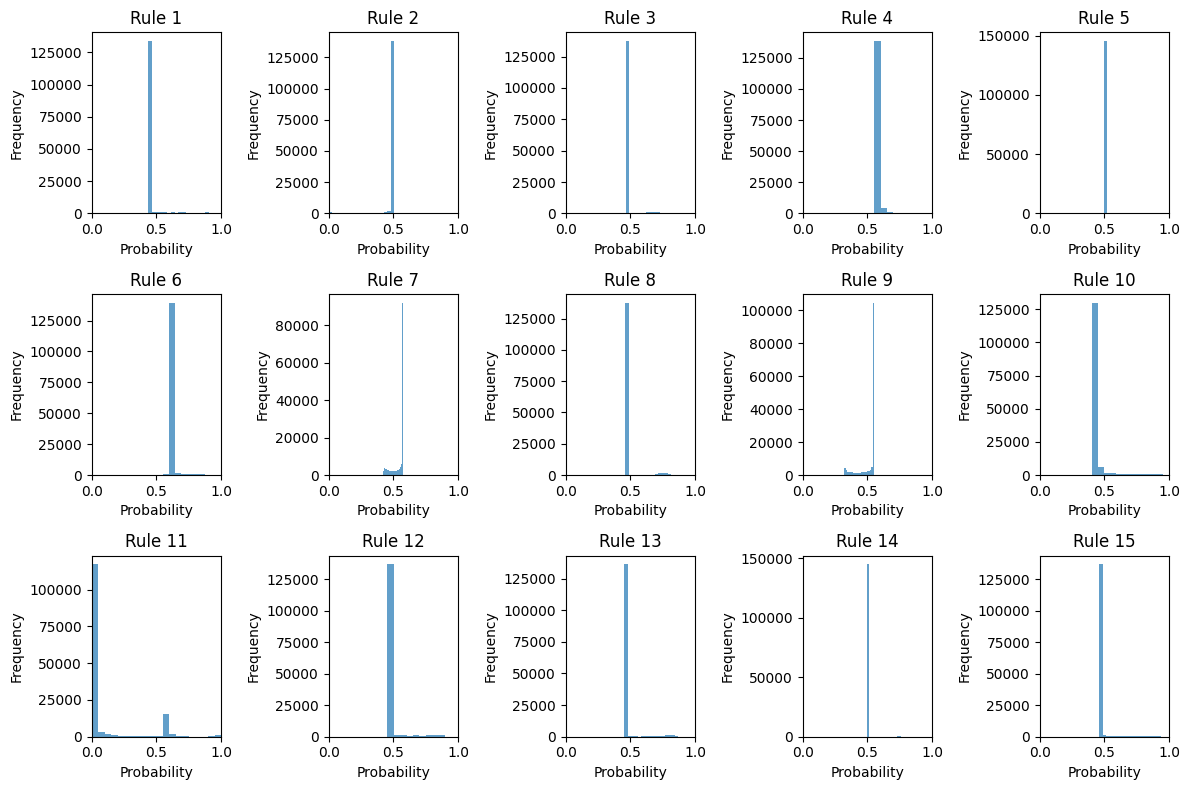

Test Accuracy: 0.9073
True Positive Rate (Recall): 59.25%
True Negative Rate: 91.16%
F1-Score: 0.7349
Average Precision: 0.6615
False Positive Rate (FPR): 0.55%

Confusion Matrix:
 [[113696    633]
 [ 12907  18764]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.90      0.99      0.94    114329
         1.0       0.97      0.59      0.73     31671

    accuracy                           0.91    146000
   macro avg       0.93      0.79      0.84    146000
weighted avg       0.91      0.91      0.90    146000

CPU times: total: 2h 28min 54s
Wall time: 21min 45s


In [15]:
%%time
class ANFIS:
    def __init__(self, n_clusters, n_features, n_classes, X_train):
        self.n_clusters = n_clusters
        self.n_features = n_features
        self.n_classes = n_classes
        
        # Initialize cluster centers using KMeans
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans.fit(X_train)
        self.cluster_centers_ = kmeans.cluster_centers_
        self.std_devs_ = np.ones(n_clusters)
        
        # Initialize RidgeClassifiers
        self.ridge_classifiers = [RidgeClassifier(alpha=1, solver='lsqr', max_iter=1000) for _ in range(n_clusters)]
    
    def _fuzzyfication(self, X):
        u = np.zeros((X.shape[0], self.n_clusters))
        for i in range(self.n_clusters):
            std_dev = max(self.std_devs_[i], 1e-6)
            # Compute the product of the Gaussian functions
            u[:, i] = np.prod(np.exp(-0.5 * (X - self.cluster_centers_[i])**2 / std_dev**2), axis=1)
        return u / np.sum(u, axis=1, keepdims=True)  # Normalize to get firing strengths

    
    def fit(self, X_train, y_train, X_val, y_val, epochs=100, learning_rate=0.001, std_dev_learning_rate=0.001, patience=20, threshold=0.5):
        best_val_accuracy = 0
        epochs_since_last_improvement = 0
        
        # Store best parameters
        best_cluster_centers = self.cluster_centers_.copy()
        best_std_devs = self.std_devs_.copy()
        best_ridge_classifiers = [classifier for classifier in self.ridge_classifiers]
    
        for epoch in range(epochs):
            u_train = self._fuzzyfication(X_train)
        
            # Update RidgeClassifiers based on weighted inputs
            for r in range(self.n_clusters):
                weighted_X_train = X_train * u_train[:, r][:, np.newaxis]
                self.ridge_classifiers[r].fit(weighted_X_train, y_train)
    
            # Predictions for training data
            y_preds = np.zeros((X_train.shape[0], self.n_clusters))
            for r in range(self.n_clusters):
                weighted_X_train = X_train * u_train[:, r][:, np.newaxis]
                y_preds[:, r] = self.ridge_classifiers[r].decision_function(weighted_X_train)
        
            # Calculate weighted predictions for training
            weighted_preds = np.sum(y_preds * u_train, axis=1) / np.sum(u_train, axis=1)
            probabilities = 1 / (1 + np.exp(-weighted_preds))
            final_predictions = (probabilities >= threshold).astype(int)
            training_accuracy = accuracy_score(y_train, final_predictions)
    
            # Validation step
            u_val = self._fuzzyfication(X_val)
            y_val_preds = np.zeros((X_val.shape[0], self.n_clusters))
            for r in range(self.n_clusters):
                weighted_X_val = X_val * u_val[:, r][:, np.newaxis]
                y_val_preds[:, r] = self.ridge_classifiers[r].decision_function(weighted_X_val)
    
            # Calculate weighted validation predictions
            weighted_val_preds = np.sum(y_val_preds * u_val, axis=1) / np.sum(u_val, axis=1)
            probabilities_val = 1 / (1 + np.exp(-weighted_val_preds))
            val_final_predictions = (probabilities_val >= threshold).astype(int)
            validation_accuracy = accuracy_score(y_val, val_final_predictions)
    
            # Gradient descent calculations
            error = y_train - probabilities
            grad_centers = np.zeros_like(self.cluster_centers_)
            grad_std_devs = np.zeros_like(self.std_devs_)
            
            for r in range(self.n_clusters):
                u_r = u_train[:, r]
                std_dev_r = max(self.std_devs_[r], 1e-6)
                weighted_error = error * u_r
                grad_centers[r] = np.sum(weighted_error[:, np.newaxis] / std_dev_r**2, axis=0)
                squared_distances = np.sum((X_train - self.cluster_centers_[r]) ** 2, axis=1)
                grad_std_devs[r] = np.sum(weighted_error * (squared_distances / std_dev_r**3 - self.n_features / std_dev_r))
    
            # Update centers and std deviations
            self.cluster_centers_ -= learning_rate * grad_centers / len(X_train)
            self.std_devs_ = np.maximum(self.std_devs_ - std_dev_learning_rate * grad_std_devs / len(X_train), 1e-6)
    
            # Print results
            print(f'Epoch {epoch + 1}/{epochs}, Training Accuracy: {training_accuracy:.4f}, Validation Accuracy: {validation_accuracy:.4f}, Best Validation Accuracy: {best_val_accuracy:.4f}')
    
            if validation_accuracy > best_val_accuracy:
                best_val_accuracy = validation_accuracy
                epochs_since_last_improvement = 0
                
                # Update best parameters
                best_cluster_centers = self.cluster_centers_.copy()
                best_std_devs = self.std_devs_.copy()
                best_ridge_classifiers = [classifier for classifier in self.ridge_classifiers]
            else:
                epochs_since_last_improvement += 1
            
            if epochs_since_last_improvement >= patience:
                print(f'Early stopping triggered after {epoch + 1} epochs with best validation accuracy: {best_val_accuracy:.4f}')
                break
    
        # Restore best parameters at the end of training
        self.cluster_centers_ = best_cluster_centers
        self.std_devs_ = best_std_devs
        self.ridge_classifiers = best_ridge_classifiers
        
        self.print_rule_base()

    def print_rule_base(self):
        print("\nTuned Rule Base:")
        for i in range(self.n_clusters):
            rule = f"If "
            for j in range(self.n_features):
                mean = self.cluster_centers_[i][j]
                std_dev = self.std_devs_[i]
                rule += f"X{j+1} is ({mean:.3f}, {std_dev:.3f}) "
                if j < self.n_features - 1:
                    rule += "and "
            rule += f"then y = "

            cluster_coef = self.ridge_classifiers[i].coef_[0]
            cluster_intercept = self.ridge_classifiers[i].intercept_[0]

            for j in range(self.n_features):
                rule += f"{cluster_coef[j]:.2f} * X{j+1}"
                if j < self.n_features - 1:
                    rule += " + "
            rule += f" + {cluster_intercept:.2f}"
            print(rule)

    
    def test(self, X_test, y_test, threshold=0.5, sample_points=5):
        u_test = self._fuzzyfication(X_test)
        y_pred_test = np.zeros((X_test.shape[0], self.n_clusters))
    
        for r in range(self.n_clusters):
            weighted_X_test = X_test * u_test[:, r][:, np.newaxis]
            y_pred_scores = self.ridge_classifiers[r].decision_function(weighted_X_test)
            y_pred_test[:, r] = y_pred_scores
        
        # Calculate weighted predictions
        weighted_test_preds = np.sum(y_pred_test * u_test, axis=1) / np.sum(u_test, axis=1)
        
        # Apply sigmoid to each rule's predictions to get probabilities
        probabilities_test = 1 / (1 + np.exp(-y_pred_test))
    
        # Combine the probabilities with the weighted test predictions
        final_probabilities = np.sum(probabilities_test * u_test, axis=1) / np.sum(u_test, axis=1)
        final_test_predictions = (final_probabilities >= threshold).astype(int)
    
        # Print probabilities for the first few sample points
        print("\nProbabilities for each rule on first few test samples:")
        for i in range(min(sample_points, X_test.shape[0])):
            print(f"Sample {i + 1}:")
            for r in range(self.n_clusters):
                print(f"  Rule {r + 1}: Probability = {probabilities_test[i, r]:.4f}, Firing Strength = {u_test[i, r]:.4f}")
    
        # Plot histograms for each rule's probabilities
        plt.figure(figsize=(12, 8))
        for r in range(self.n_clusters):
            plt.subplot(3, 5, r + 1)  # Adjust the layout as needed
            plt.hist(probabilities_test[:, r], bins=20, alpha=0.7)
            plt.title(f'Rule {r + 1}')
            plt.xlabel('Probability')
            plt.ylabel('Frequency')
            plt.xlim(0, 1)
        
        plt.tight_layout()
        plt.show()
    
        test_accuracy = accuracy_score(y_test, final_test_predictions)
        true_positive_rate = recall_score(y_test, final_test_predictions)
        true_negative_rate = (y_test.shape[0] - confusion_matrix(y_test, final_test_predictions)[1, 0]) / y_test.shape[0]
        f1 = f1_score(y_test, final_test_predictions)
        average_precision = average_precision_score(y_test, final_test_predictions)
        fpr = confusion_matrix(y_test, final_test_predictions)[0, 1] / (confusion_matrix(y_test, final_test_predictions)[0, 1] + confusion_matrix(y_test, final_test_predictions)[0, 0])
        
        print(f'Test Accuracy: {test_accuracy:.4f}')
        print(f'True Positive Rate (Recall): {true_positive_rate * 100:.2f}%')
        print(f'True Negative Rate: {true_negative_rate * 100:.2f}%')
        print(f'F1-Score: {f1:.4f}')
        print(f'Average Precision: {average_precision:.4f}')
        print(f'False Positive Rate (FPR): {fpr * 100:.2f}%')
        
        cm = confusion_matrix(y_test, final_test_predictions)
        print("\nConfusion Matrix:\n", cm)
        
        report = classification_report(y_test, final_test_predictions, zero_division=0)
        print("\nClassification Report:\n", report)

    
    def save_model(self, filename):
        with open(filename, 'wb') as file:
            pickle.dump(self, file)
        print(f'Model saved to {filename}')

    @classmethod
    def load_model(cls, filename):
        with open(filename, 'rb') as file:
            model = pickle.load(file)
        print(f'Model loaded from {filename}')
        return model

# Example usage
n_clusters = 15  # Number of clusters
n_features = 10  # Update with actual feature count
n_classes = 2  # Update with actual class labels

# Split training data into training and validation sets
X_train_resampled, X_val, y_train_resampled, y_val = train_test_split(X_train_resampled, y_train_resampled, test_size=0.2, random_state=42)

# Fit the model with the resampled training data
model = ANFIS(n_clusters=n_clusters, n_features=n_features, n_classes=n_classes, X_train=X_train_resampled)
model.fit(X_train_resampled, y_train_resampled, X_val, y_val, epochs=100, learning_rate=0.1, std_dev_learning_rate=0.1, patience=2000)

# Save the trained model
model.save_model('ANFIS-1-km-cost.pkl')

# Load the model and test it with the original test data
loaded_model = ANFIS.load_model

# Load the model and test it with the original test data
loaded_model = ANFIS.load_model('ANFIS-1-km-cost.pkl')
loaded_model.test(X_test, y_test, sample_points=1)  # Adjust sample_points as needed
# worder

## ANFIS-GD-KM-0 order

Epoch 1/100, MSE: 0.1622, Training Accuracy: 0.8413, Validation Accuracy: 0.8397, Best Validation Accuracy: 0.0000
Epoch 2/100, MSE: 0.1622, Training Accuracy: 0.8411, Validation Accuracy: 0.8396, Best Validation Accuracy: 0.8397
Epoch 3/100, MSE: 0.1623, Training Accuracy: 0.8409, Validation Accuracy: 0.8393, Best Validation Accuracy: 0.8397
Epoch 4/100, MSE: 0.1625, Training Accuracy: 0.8406, Validation Accuracy: 0.8390, Best Validation Accuracy: 0.8397
Epoch 5/100, MSE: 0.1627, Training Accuracy: 0.8405, Validation Accuracy: 0.8391, Best Validation Accuracy: 0.8397
Epoch 6/100, MSE: 0.1630, Training Accuracy: 0.8408, Validation Accuracy: 0.8394, Best Validation Accuracy: 0.8397
Epoch 7/100, MSE: 0.1633, Training Accuracy: 0.8413, Validation Accuracy: 0.8399, Best Validation Accuracy: 0.8397
Epoch 8/100, MSE: 0.1639, Training Accuracy: 0.8420, Validation Accuracy: 0.8407, Best Validation Accuracy: 0.8399
Epoch 9/100, MSE: 0.1645, Training Accuracy: 0.8429, Validation Accuracy: 0.8416

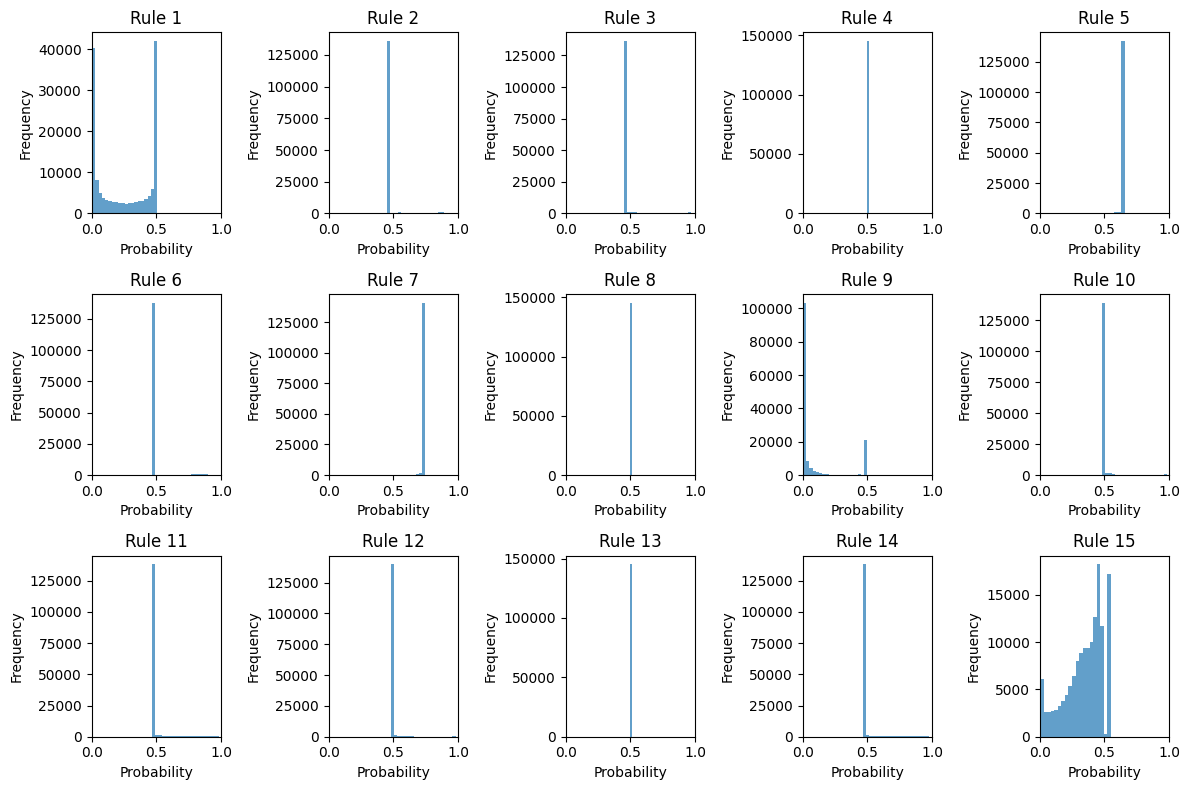

Test Accuracy: 0.8988
True Positive Rate (Recall): 53.49%
True Negative Rate: 89.91%
F1-Score: 0.6964
Average Precision: 0.6345
False Positive Rate (FPR): 0.04%

Confusion Matrix:
 [[114287     42]
 [ 14729  16942]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.89      1.00      0.94    114329
         1.0       1.00      0.53      0.70     31671

    accuracy                           0.90    146000
   macro avg       0.94      0.77      0.82    146000
weighted avg       0.91      0.90      0.89    146000

CPU times: total: 1h 5min 11s
Wall time: 10min 30s


In [16]:
%%time
# zero order better mse
class ANFIS:
    def __init__(self, n_clusters, n_features, n_classes, X_train, X_train_1, X_val_1, X_test_1, random_state=42):
        self.n_clusters = n_clusters
        self.n_features = n_features
        self.n_classes = n_classes

        self.X_train_1 = np.ones((X_train.shape[0], 1))
        self.X_val_1 = np.ones((X_val.shape[0], 1))
        self.X_test_1 = np.ones((X_test.shape[0], 1))

        # Initialize cluster centers using KMeans
        kmeans = KMeans(n_clusters=n_clusters, random_state= random_state)
        kmeans.fit(X_train)
        self.cluster_centers_ = kmeans.cluster_centers_
        self.std_devs_ = np.ones(n_clusters)
        
        # Initialize RidgeClassifiers
        self.ridge_classifiers = [RidgeClassifier(alpha=1.0, solver='lsqr', max_iter=1000) for _ in range(n_clusters)]


    
    def _fuzzyfication(self, X):
        u = np.zeros((X.shape[0], self.n_clusters))
        for i in range(self.n_clusters):
            std_dev = max(self.std_devs_[i], 1e-6)
            # Compute the product of the Gaussian functions
            u[:, i] = np.prod(np.exp(-0.5 * (X - self.cluster_centers_[i])**2 / std_dev**2), axis=1)
        return u / np.sum(u, axis=1, keepdims=True)  # Normalize to get firing strengths

    
    def fit(self, X_train, y_train, X_val, y_val, epochs=100, learning_rate=0.001, std_dev_learning_rate=0.001, patience=20, threshold=0.5):
        best_val_accuracy = 0
        epochs_since_last_improvement = 0
        
        # Store best parameters
        best_cluster_centers = self.cluster_centers_.copy()
        best_std_devs = self.std_devs_.copy()
        best_ridge_classifiers = [classifier for classifier in self.ridge_classifiers]
    
        for epoch in range(epochs):
            u_train = self._fuzzyfication(X_train)
    
            # Update RidgeClassifiers based on weighted inputs
            for r in range(self.n_clusters):
                weighted_X_train = self.X_train_1 * u_train[:, r][:, np.newaxis]
                self.ridge_classifiers[r].fit(weighted_X_train, y_train)
    
            # Predictions for each rule using decision_function
            y_preds = np.zeros((X_train.shape[0], self.n_clusters))
            for r in range(self.n_clusters):
                weighted_X_train = self.X_train_1 * u_train[:, r][:, np.newaxis]
                y_preds[:, r] = self.ridge_classifiers[r].decision_function(weighted_X_train)
    
            # Calculate weighted predictions
            weighted_preds = np.sum(y_preds * u_train, axis=1) / np.sum(u_train, axis=1)
            
            # Apply sigmoid to get probabilities
            probabilities = 1 / (1 + np.exp(-weighted_preds))
            final_predictions = (probabilities >= threshold).astype(int)
            training_accuracy = accuracy_score(y_train, final_predictions)
            
            # Calculate Mean Squared Error (MSE)
            mse = np.mean((y_train - probabilities) ** 2)
            
            # Validation step
            u_val = self._fuzzyfication(X_val)
            y_val_preds = np.zeros((X_val.shape[0], self.n_clusters))
            for r in range(self.n_clusters):
                weighted_X_val = self.X_val_1 * u_val[:, r][:, np.newaxis]
                y_val_preds[:, r] = self.ridge_classifiers[r].decision_function(weighted_X_val)
    
            # Calculate weighted validation predictions
            weighted_val_preds = np.sum(y_val_preds * u_val, axis=1) / np.sum(u_val, axis=1)
            probabilities_val = 1 / (1 + np.exp(-weighted_val_preds))
            val_final_predictions = (probabilities_val >= threshold).astype(int)
            validation_accuracy = accuracy_score(y_val, val_final_predictions)
    
            # Gradient descent calculations
            error = y_train - probabilities
            grad_centers = np.zeros_like(self.cluster_centers_)
            grad_std_devs = np.zeros_like(self.std_devs_)
    
            for r in range(self.n_clusters):
                u_r = u_train[:, r]
                std_dev_r = max(self.std_devs_[r], 1e-6)
                # Calculate gradients
                weighted_error = error * u_r
                grad_centers[r] = np.sum(weighted_error[:, np.newaxis] / std_dev_r**2, axis=0)
                # Calculate squared distances directly
                squared_distances = np.sum((X_train - self.cluster_centers_[r]) ** 2, axis=1)
                grad_std_devs[r] = np.sum(weighted_error * (squared_distances / std_dev_r**3 - self.n_features / std_dev_r))
    
            # Update centers and std deviations
            self.cluster_centers_ -= learning_rate * grad_centers / len(X_train)
            self.std_devs_ = np.maximum(self.std_devs_ - std_dev_learning_rate * grad_std_devs / len(X_train), 1e-6)
    
            # Print results
            print(f'Epoch {epoch + 1}/{epochs}, MSE: {mse:.4f}, Training Accuracy: {training_accuracy:.4f}, Validation Accuracy: {validation_accuracy:.4f}, Best Validation Accuracy: {best_val_accuracy:.4f}')
    
            if validation_accuracy > best_val_accuracy:
                best_val_accuracy = validation_accuracy
                epochs_since_last_improvement = 0
                
                # Update best parameters
                best_cluster_centers = self.cluster_centers_.copy()
                best_std_devs = self.std_devs_.copy()
                best_ridge_classifiers = [classifier for classifier in self.ridge_classifiers]
            else:
                epochs_since_last_improvement += 1
            
            if epochs_since_last_improvement >= patience:
                print(f'Early stopping triggered after {epoch + 1} epochs with best validation accuracy: {best_val_accuracy:.4f}')
                break
    
        # Restore best parameters at the end of training
        self.cluster_centers_ = best_cluster_centers
        self.std_devs_ = best_std_devs
        self.ridge_classifiers = best_ridge_classifiers
        
        self.print_rule_base()

    def print_rule_base(self):
        print("\nTuned Rule Base:")
        for i in range(self.n_clusters):
            rule = f"If "
            for j in range(self.n_features):
                mean = self.cluster_centers_[i][j]
                std_dev = self.std_devs_[i]
                rule += f"X{j+1} is ({mean:.3f}, {std_dev:.3f}) "
                if j < self.n_features - 1:
                    rule += "and "
            rule += f"then y = {self.ridge_classifiers[i].intercept_[0]:.2f}"
            print(rule)

    
    def test(self, X_test, y_test, threshold=0.5, sample_points=5):
        u_test = self._fuzzyfication(X_test)
        y_pred_test = np.zeros((X_test.shape[0], self.n_clusters))
    
        for r in range(self.n_clusters):
            weighted_X_test = X_test_1 * u_test[:, r][:, np.newaxis]
            y_pred_scores = self.ridge_classifiers[r].decision_function(weighted_X_test)
            y_pred_test[:, r] = y_pred_scores
        
        # Calculate weighted predictions
        weighted_test_preds = np.sum(y_pred_test * u_test, axis=1) / np.sum(u_test, axis=1)
        
        # Apply sigmoid to each rule's predictions to get probabilities
        probabilities_test = 1 / (1 + np.exp(-y_pred_test))
    
        # Combine the probabilities with the weighted test predictions
        final_probabilities = np.sum(probabilities_test * u_test, axis=1) / np.sum(u_test, axis=1)
        final_test_predictions = (final_probabilities >= threshold).astype(int)
    
        # Print probabilities for the first few sample points
        print("\nProbabilities for each rule on first few test samples:")
        for i in range(min(sample_points, X_test.shape[0])):
            print(f"Sample {i + 1}:")
            for r in range(self.n_clusters):
                print(f"  Rule {r + 1}: Probability = {probabilities_test[i, r]:.4f}, Firing Strength = {u_test[i, r]:.4f}")
    
        # Plot histograms for each rule's probabilities
        plt.figure(figsize=(12, 8))
        for r in range(self.n_clusters):
            plt.subplot(3, 5, r + 1)  # Adjust the layout as needed
            plt.hist(probabilities_test[:, r], bins=20, alpha=0.7)
            plt.title(f'Rule {r + 1}')
            plt.xlabel('Probability')
            plt.ylabel('Frequency')
            plt.xlim(0, 1)
        
        plt.tight_layout()
        plt.show()
    
        test_accuracy = accuracy_score(y_test, final_test_predictions)
        true_positive_rate = recall_score(y_test, final_test_predictions)
        true_negative_rate = (y_test.shape[0] - confusion_matrix(y_test, final_test_predictions)[1, 0]) / y_test.shape[0]
        f1 = f1_score(y_test, final_test_predictions)
        average_precision = average_precision_score(y_test, final_test_predictions)
        fpr = confusion_matrix(y_test, final_test_predictions)[0, 1] / (confusion_matrix(y_test, final_test_predictions)[0, 1] + confusion_matrix(y_test, final_test_predictions)[0, 0])
        
        print(f'Test Accuracy: {test_accuracy:.4f}')
        print(f'True Positive Rate (Recall): {true_positive_rate * 100:.2f}%')
        print(f'True Negative Rate: {true_negative_rate * 100:.2f}%')
        print(f'F1-Score: {f1:.4f}')
        print(f'Average Precision: {average_precision:.4f}')
        print(f'False Positive Rate (FPR): {fpr * 100:.2f}%')
        
        cm = confusion_matrix(y_test, final_test_predictions)
        print("\nConfusion Matrix:\n", cm)
        
        report = classification_report(y_test, final_test_predictions, zero_division=0)
        print("\nClassification Report:\n", report)

    
    def save_model(self, filename):
        with open(filename, 'wb') as file:
            pickle.dump(self, file)
        print(f'Model saved to {filename}')

    @classmethod
    def load_model(cls, filename):
        with open(filename, 'rb') as file:
            model = pickle.load(file)
        print(f'Model loaded from {filename}')
        return model

# Example usage
n_clusters = 15  # Number of clusters
n_features = 10  # Update with actual feature count
n_classes = 2  # Update with actual class labels

# Split training data into training and validation sets
X_train_resampled, X_val, y_train_resampled, y_val = train_test_split(X_train_resampled, y_train_resampled, test_size=0.2, random_state=42)

# the empty matrix that stores the zero order consequents
# Assuming you have X_train, X_val, and X_test defined earlier
X_train_1 = np.ones((X_train_resampled.shape[0], 1))  # Modify as necessary
X_val_1 = np.ones((X_val.shape[0], 1))  # Modify as necessary
X_test_1 = np.ones((X_test.shape[0], 1))  # Modify as necessary


# Fit the model with the resampled training data
# Fit the model with the resampled training data
model = ANFIS(n_clusters=n_clusters, n_features=n_features, n_classes=n_classes, 
              X_train=X_train_resampled, 
              X_train_1=X_train_1, 
              X_val_1=X_val_1, 
              X_test_1=X_test_1, random_state=42)
model.fit(X_train_resampled, y_train_resampled, X_val, y_val, epochs=100, learning_rate=0.1, std_dev_learning_rate=0.1, patience=2000)

# Save the trained model
model.save_model('ANFIS-0-km.pkl')

# Load the model and test it with the original test data
loaded_model = ANFIS.load_model

# Load the model and test it with the original test data
loaded_model = ANFIS.load_model('ANFIS-0-km.pkl')
loaded_model.test(X_test, y_test, sample_points=1)  # Adjust sample_points as needed
# ready!!

## ANFIS-GP-1st order SGD

Epoch 1/100, Training Accuracy: 0.8432, Validation Accuracy: 0.8427, Loss: 4.8380, Best Validation Accuracy: 0.0000
Epoch 2/100, Training Accuracy: 0.8434, Validation Accuracy: 0.8428, Loss: 4.8430, Best Validation Accuracy: 0.8427
Epoch 3/100, Training Accuracy: 0.8435, Validation Accuracy: 0.8429, Loss: 4.8469, Best Validation Accuracy: 0.8428
Epoch 4/100, Training Accuracy: 0.8437, Validation Accuracy: 0.8430, Loss: 4.8512, Best Validation Accuracy: 0.8429
Epoch 5/100, Training Accuracy: 0.8438, Validation Accuracy: 0.8431, Loss: 4.8548, Best Validation Accuracy: 0.8430
Epoch 6/100, Training Accuracy: 0.8440, Validation Accuracy: 0.8432, Loss: 4.8593, Best Validation Accuracy: 0.8431
Epoch 7/100, Training Accuracy: 0.8441, Validation Accuracy: 0.8434, Loss: 4.8645, Best Validation Accuracy: 0.8432
Epoch 8/100, Training Accuracy: 0.8442, Validation Accuracy: 0.8435, Loss: 4.8692, Best Validation Accuracy: 0.8434
Epoch 9/100, Training Accuracy: 0.8444, Validation Accuracy: 0.8437, Los

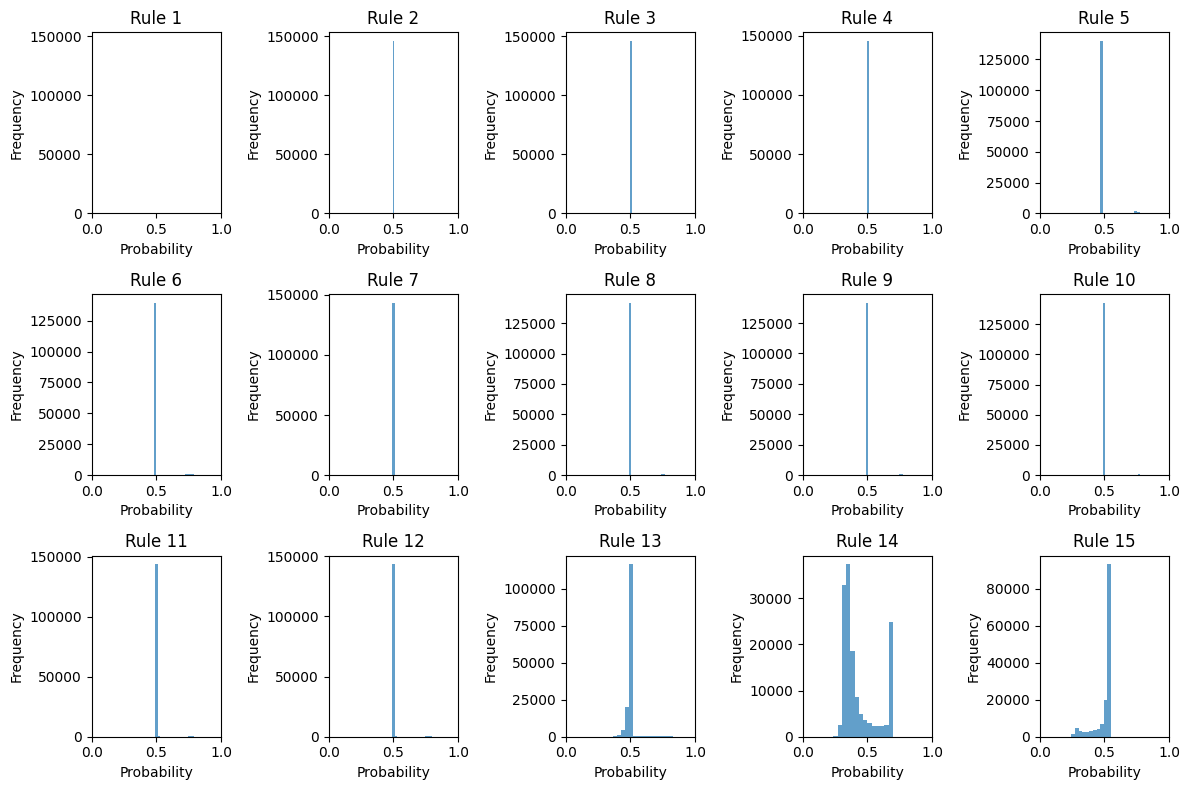

Test Accuracy: 0.9181
True Positive Rate (Recall): 72.26%
True Negative Rate: 93.98%
F1 Score: 0.7929
Average Precision: 0.6948
False Positive Rate: 0.0277

Confusion Matrix:
 [[111157   3172]
 [  8785  22886]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.93      0.97      0.95    114329
         1.0       0.88      0.72      0.79     31671

    accuracy                           0.92    146000
   macro avg       0.90      0.85      0.87    146000
weighted avg       0.92      0.92      0.92    146000

CPU times: total: 1h 54min 37s
Wall time: 17min 27s


In [17]:
%%time
class ANFIS:
    def __init__(self, n_clusters, n_features, n_classes, X_train, random_state=42):
        self.n_clusters = n_clusters
        self.n_features = n_features
        self.n_classes = n_classes

        # Initialize cluster centers over the range of the features
        self.cluster_centers_ = np.array([
            np.linspace(np.min(X_train[:, i]), np.max(X_train[:, i]), n_clusters)
            for i in range(n_features)
        ]).T
        
        # Calculate standard deviation as range divided by (n_clusters - 1)
        self.std_devs_ = (np.max(X_train, axis=0) - np.min(X_train, axis=0)) / (n_clusters - 1)
        self.std_devs_ = np.tile(self.std_devs_, (n_clusters, 1))

        # Initialize RidgeClassifiers for consequent
        self.ridge_classifiers = [RidgeClassifier(alpha=1.0, solver='lsqr') for _ in range(n_clusters)]
        
        # Initialize SGDClassifier for updating cluster centers
        self.sgd_classifiers = [SGDClassifier(loss='log_loss', learning_rate='constant', eta0=0.1) for _ in range(n_clusters)]


    def _fuzzyfication(self, X):
        u = np.zeros((X.shape[0], self.n_clusters))
        for i in range(self.n_clusters):
            std_dev = np.maximum(self.std_devs_[i], 1e-6)
            u[:, i] = np.prod(np.exp(-0.5 * (X - self.cluster_centers_[i])**2 / std_dev**2), axis=1)
        return u / np.sum(u, axis=1, keepdims=True)
    
    def fit(self, X_train, y_train, X_val, y_val, epochs=100, learning_rate=0.001, std_dev_learning_rate=0.001, patience=20, threshold=0.5):
        best_val_accuracy = 0
        epochs_since_last_improvement = 0
    
        for epoch in range(epochs):
            u_train = self._fuzzyfication(X_train)
    
            for r in range(self.n_clusters):
                weighted_X_train = X_train * u_train[:, r][:, np.newaxis]  # Use X_train directly
                self.ridge_classifiers[r].fit(weighted_X_train, y_train)
    
            y_preds = np.zeros((X_train.shape[0], self.n_clusters))
            for r in range(self.n_clusters):
                weighted_X_train = X_train * u_train[:, r][:, np.newaxis]  # Use X_train directly
                y_preds[:, r] = self.ridge_classifiers[r].decision_function(weighted_X_train)
    
            weighted_preds = np.sum(y_preds * u_train, axis=1) / np.sum(u_train, axis=1)
            probabilities = 1 / (1 + np.exp(-weighted_preds))
            final_predictions = (probabilities >= threshold).astype(int)
            training_accuracy = accuracy_score(y_train, final_predictions)
    
            u_val = self._fuzzyfication(X_val)
            y_val_preds = np.zeros((X_val.shape[0], self.n_clusters))
            for r in range(self.n_clusters):
                weighted_X_val = X_val * u_val[:, r][:, np.newaxis]  # Use X_val directly
                y_val_preds[:, r] = self.ridge_classifiers[r].decision_function(weighted_X_val)
    
            weighted_val_preds = np.sum(y_val_preds * u_val, axis=1) / np.sum(u_val, axis=1)
            probabilities_val = 1 / (1 + np.exp(-weighted_val_preds))
            val_final_predictions = (probabilities_val >= threshold).astype(int)
            validation_accuracy = accuracy_score(y_val, val_final_predictions)
    
            # Calculate binary cross-entropy error
            loss = log_loss(y_train, weighted_preds)  # Define loss here
            
            for r in range(self.n_clusters):
                diff = X_train - self.cluster_centers_[r]
                u_r = u_train[:, r]
                std_dev_r = self.std_devs_[r]

                grad_centers = np.sum(
                    ((1 / (1 + np.exp(-y_preds[:,r]))) - y_train)[:, np.newaxis] * u_r[:, np.newaxis] * (1 - u_r[:, np.newaxis]) * diff / std_dev_r**2,
                    axis=0
                )
                self.cluster_centers_[r] -= learning_rate * grad_centers / len(X_train)
    
                self.sgd_classifiers[r].partial_fit(u_train[:, r].reshape(-1, 1), y_train, classes=np.unique(y_train))
                self.cluster_centers_[r] -= self.sgd_classifiers[r].coef_[0][:self.n_features] * (1 / len(X_train))
    
            print(f'Epoch {epoch + 1}/{epochs}, Training Accuracy: {training_accuracy:.4f}, Validation Accuracy: {validation_accuracy:.4f}, Loss: {loss:.4f}, Best Validation Accuracy: {best_val_accuracy:.4f}')
    
            if validation_accuracy > best_val_accuracy:
                best_val_accuracy = validation_accuracy
                epochs_since_last_improvement = 0
            else:
                epochs_since_last_improvement += 1
    
            if epochs_since_last_improvement >= patience:
                print(f'Early stopping triggered after {epoch + 1} epochs with best validation accuracy: {best_val_accuracy:.4f}')
                break
    
        self.print_rule_base()

    def print_rule_base(self):
        print("\nTuned Rule Base:")
        for i in range(self.n_clusters):
            rule = f"If "
            for j in range(self.n_features):
                mean = self.cluster_centers_[i][j]
                std_dev = self.std_devs_[i][j]
                rule += f"X{j+1} is ({mean:.3f}, {std_dev:.3f}) "
                if j < self.n_features - 1:
                    rule += "and "
            rule += f"then y = "

            cluster_coef = self.ridge_classifiers[i].coef_[0]
            cluster_intercept = self.ridge_classifiers[i].intercept_[0]

            for j in range(self.n_features):
                rule += f"{cluster_coef[j]:.2f} * X{j+1}"
                if j < self.n_features - 1:
                    rule += " + "
            rule += f" + {cluster_intercept:.2f}"
            print(rule)


    def test(self, X_test, y_test, threshold=0.5, sample_points=5):
        u_test = self._fuzzyfication(X_test)
        y_pred_test = np.zeros((X_test.shape[0], self.n_clusters))
        
        for r in range(self.n_clusters):
            weighted_X_test = X_test * u_test[:, r][:, np.newaxis]  # Corrected line
            y_pred_scores = self.ridge_classifiers[r].decision_function(weighted_X_test)
            y_pred_test[:, r] = y_pred_scores
        
        probabilities_test = 1 / (1 + np.exp(-y_pred_test))
        weighted_test_preds = np.sum(y_pred_test * u_test, axis=1) / np.sum(u_test, axis=1)
        final_probabilities = 1 / (1 + np.exp(-weighted_test_preds))  # Final probabilities for classification
        final_test_predictions = (final_probabilities >= threshold).astype(int) 
    
        print("\nProbabilities for each rule on first few test samples:")
        for i in range(min(sample_points, X_test.shape[0])):
            print(f"Sample {i + 1}:")
            for r in range(self.n_clusters):
                print(f"  Rule {r + 1}: Probability = {probabilities_test[i, r]:.4f}, Firing Strength = {u_test[i, r]:.4f}")
    
        plt.figure(figsize=(12, 8))
        for r in range(self.n_clusters):
            plt.subplot(3, 5, r + 1)
            plt.hist(probabilities_test[:, r], bins=20, alpha=0.7)
            plt.title(f'Rule {r + 1}')
            plt.xlabel('Probability')
            plt.ylabel('Frequency')
            plt.xlim(0, 1)
        
        plt.tight_layout()
        plt.show()
    
        test_accuracy = accuracy_score(y_test, final_test_predictions)
        true_positive_rate = recall_score(y_test, final_test_predictions)
        true_negative_rate = (y_test.shape[0] - confusion_matrix(y_test, final_test_predictions)[1, 0]) / y_test.shape[0]
        f1 = f1_score(y_test, final_test_predictions)
        average_precision = average_precision_score(y_test, final_test_predictions)
        fpr = confusion_matrix(y_test, final_test_predictions)[0, 1] / (confusion_matrix(y_test, final_test_predictions)[0, 1] + confusion_matrix(y_test, final_test_predictions)[0, 0])
        
        print(f'Test Accuracy: {test_accuracy:.4f}')
        print(f'True Positive Rate (Recall): {true_positive_rate * 100:.2f}%')
        print(f'True Negative Rate: {true_negative_rate * 100:.2f}%')
        print(f'F1 Score: {f1:.4f}')
        print(f'Average Precision: {average_precision:.4f}')
        print(f'False Positive Rate: {fpr:.4f}')
        
        cm = confusion_matrix(y_test, final_test_predictions)
        print("\nConfusion Matrix:\n", cm)
        
        report = classification_report(y_test, final_test_predictions, zero_division=0)
        print("\nClassification Report:\n", report)

    
    def save_model(self, filename):
        with open(filename, 'wb') as file:
            pickle.dump(self, file)
        print(f'Model saved to {filename}')

    @classmethod
    def load_model(cls, filename):
        with open(filename, 'rb') as file:
            model = pickle.load(file)
        print(f'Model loaded from {filename}')
        return model

# Example usage
n_clusters = 15  # Number of clusters
n_features = 10  # Update with actual feature count
n_classes = 2  # Update with actual class labels

# Split training data into training and validation sets
X_train_resampled, X_val, y_train_resampled, y_val = train_test_split(X_train_resampled, y_train_resampled, test_size=0.2, random_state=42)




# Fit the model with the resampled training data
# Fit the model with the resampled training data
model = ANFIS(n_clusters=n_clusters, n_features=n_features, n_classes=n_classes, X_train=X_train_resampled, random_state=42)
model.fit(X_train_resampled, y_train_resampled, X_val, y_val, epochs=100, learning_rate=0.1, std_dev_learning_rate=0.1, patience=2000)

# Save the trained model
model.save_model('ANFIS-1-gp1.pkl')

# Load the model and test it with the original test data
loaded_model = ANFIS.load_model

# Load the model and test it with the original test data
loaded_model = ANFIS.load_model('ANFIS-1-gp1.pkl')
loaded_model.test(X_test, y_test, sample_points=1)  # Adjust sample_points as needed
# ready!!

## ANFIS-GP-0st order -SGD

Epoch 1/100, Training Accuracy: 0.8448, Validation Accuracy: 0.8453, Loss: 5.1263, Best Validation Accuracy: 0.0000
Epoch 2/100, Training Accuracy: 0.8448, Validation Accuracy: 0.8453, Loss: 5.1289, Best Validation Accuracy: 0.8453
Epoch 3/100, Training Accuracy: 0.8448, Validation Accuracy: 0.8454, Loss: 5.1301, Best Validation Accuracy: 0.8453
Epoch 4/100, Training Accuracy: 0.8448, Validation Accuracy: 0.8452, Loss: 5.1327, Best Validation Accuracy: 0.8454
Epoch 5/100, Training Accuracy: 0.8449, Validation Accuracy: 0.8453, Loss: 5.1352, Best Validation Accuracy: 0.8454
Epoch 6/100, Training Accuracy: 0.8448, Validation Accuracy: 0.8453, Loss: 5.1381, Best Validation Accuracy: 0.8454
Epoch 7/100, Training Accuracy: 0.8449, Validation Accuracy: 0.8454, Loss: 5.1404, Best Validation Accuracy: 0.8454
Epoch 8/100, Training Accuracy: 0.8449, Validation Accuracy: 0.8453, Loss: 5.1421, Best Validation Accuracy: 0.8454
Epoch 9/100, Training Accuracy: 0.8449, Validation Accuracy: 0.8453, Los

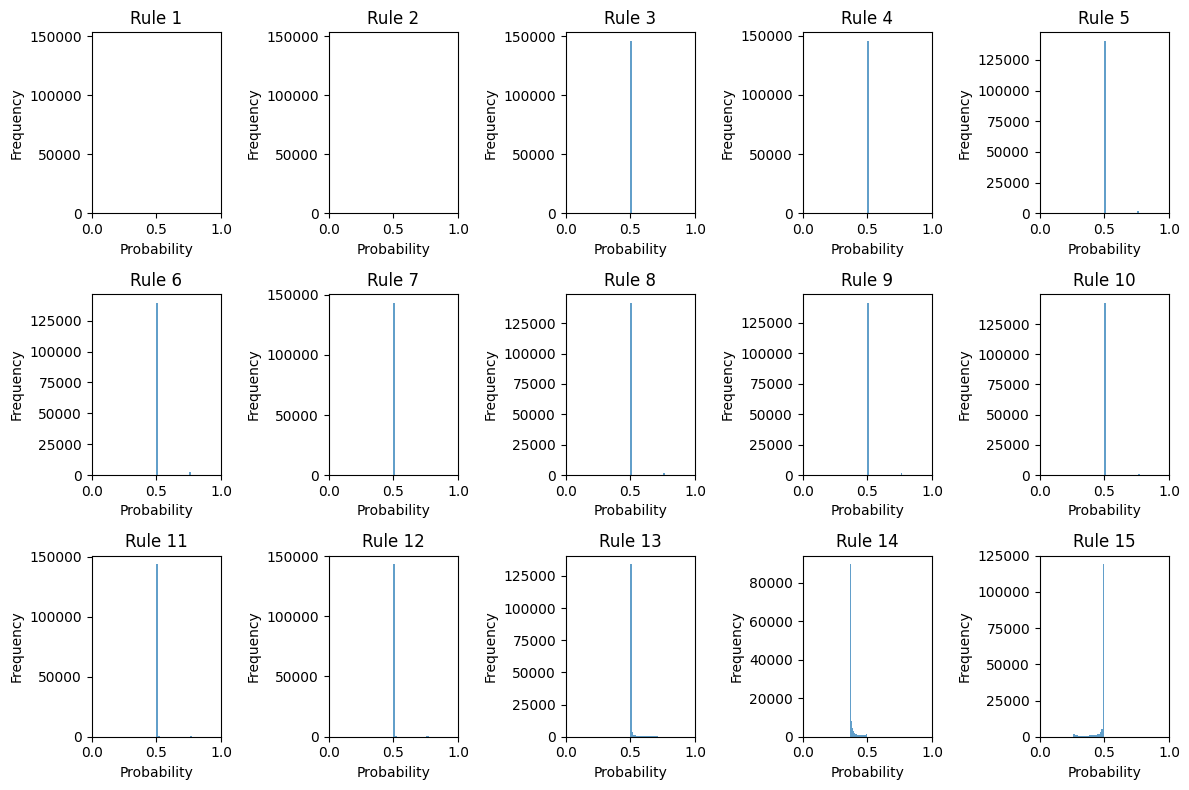

Test Accuracy: 0.9271
True Positive Rate (Recall): 69.69%
True Negative Rate: 93.43%
F1 Score: 0.8057
Average Precision: 0.7310
False Positive Rate: 0.0092

Confusion Matrix:
 [[113279   1050]
 [  9598  22073]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.92      0.99      0.96    114329
         1.0       0.95      0.70      0.81     31671

    accuracy                           0.93    146000
   macro avg       0.94      0.84      0.88    146000
weighted avg       0.93      0.93      0.92    146000

CPU times: total: 45min 44s
Wall time: 10min 5s


In [18]:
%%time

class ANFIS:
    def __init__(self, n_clusters, n_features, n_classes, X_train, X_train_1, X_val_1, X_test_1, random_state=42):
        self.n_clusters = n_clusters
        self.n_features = n_features
        self.n_classes = n_classes

        # Initialize cluster centers over the range of the features
        self.cluster_centers_ = np.array([
            np.linspace(np.min(X_train[:, i]), np.max(X_train[:, i]), n_clusters)
            for i in range(n_features)
        ]).T
        
        # Calculate standard deviation as range divided by (n_clusters - 1)
        self.std_devs_ = (np.max(X_train, axis=0) - np.min(X_train, axis=0)) / (n_clusters - 1)
        self.std_devs_ = np.tile(self.std_devs_, (n_clusters, 1))

        # Initialize RidgeClassifiers for consequent
        self.ridge_classifiers = [RidgeClassifier(alpha=1.0, solver='lsqr', fit_intercept=False) for _ in range(n_clusters)]
        
        # Initialize SGDClassifier for updating cluster centers
        self.sgd_classifiers = [SGDClassifier(loss='log_loss', learning_rate='constant', eta0=0.1) for _ in range(n_clusters)]
      
        self.X_train_1 = np.ones((X_train.shape[0], 1))
        self.X_val_1 = np.ones((X_val.shape[0], 1))
        self.X_test_1 = np.ones((X_test.shape[0], 1))

    def _fuzzyfication(self, X):
        u = np.zeros((X.shape[0], self.n_clusters))
        for i in range(self.n_clusters):
            std_dev = np.maximum(self.std_devs_[i], 1e-6)
            u[:, i] = np.prod(np.exp(-0.5 * (X - self.cluster_centers_[i])**2 / std_dev**2), axis=1)
        return u / np.sum(u, axis=1, keepdims=True)

    def fit(self, X_train, y_train, X_val, y_val, epochs=100, learning_rate=0.001, std_dev_learning_rate=0.001, patience=20, threshold=0.5):
        best_val_accuracy = 0
        epochs_since_last_improvement = 0
    
        for epoch in range(epochs):
            u_train = self._fuzzyfication(X_train)
    
            for r in range(self.n_clusters):
                weighted_X_train = self.X_train_1 * u_train[:, r][:, np.newaxis]
                self.ridge_classifiers[r].fit(weighted_X_train, y_train)
    
            y_preds = np.zeros((X_train.shape[0], self.n_clusters))
            for r in range(self.n_clusters):
                weighted_X_train = self.X_train_1 * u_train[:, r][:, np.newaxis]
                y_preds[:, r] = self.ridge_classifiers[r].decision_function(weighted_X_train)
    
            weighted_preds = np.sum(y_preds * u_train, axis=1) / np.sum(u_train, axis=1)
            probabilities = 1 / (1 + np.exp(-weighted_preds))
            final_predictions = (probabilities >= threshold).astype(int)
            training_accuracy = accuracy_score(y_train, final_predictions)
    
            u_val = self._fuzzyfication(X_val)
            y_val_preds = np.zeros((X_val.shape[0], self.n_clusters))
            for r in range(self.n_clusters):
                weighted_X_val = self.X_val_1 * u_val[:, r][:, np.newaxis]
                y_val_preds[:, r] = self.ridge_classifiers[r].decision_function(weighted_X_val)
    
            weighted_val_preds = np.sum(y_val_preds * u_val, axis=1) / np.sum(u_val, axis=1)
            probabilities_val = 1 / (1 + np.exp(-weighted_val_preds))
            val_final_predictions = (probabilities_val >= threshold).astype(int)
            validation_accuracy = accuracy_score(y_val, val_final_predictions)
    
            # Calculate binary cross-entropy error
            loss = log_loss(y_train, weighted_preds)  # Define loss here
            
            for r in range(self.n_clusters):
                diff = X_train - self.cluster_centers_[r]
                u_r = u_train[:, r]
                std_dev_r = self.std_devs_[r]

                grad_centers = np.sum(
                    ((1 / (1 + np.exp(-y_preds[:, r])) - y_train)[:, np.newaxis] * u_r[:, np.newaxis] * (1 - u_r[:, np.newaxis]) * diff / std_dev_r**2),
                    axis=0)
                self.cluster_centers_[r] -= learning_rate * grad_centers / len(X_train)

                self.sgd_classifiers[r].partial_fit(u_train[:, r].reshape(-1, 1), y_train, classes=np.unique(y_train))
                self.cluster_centers_[r] -= self.sgd_classifiers[r].coef_[0][:self.n_features] * (1 / len(X_train))
    
            print(f'Epoch {epoch + 1}/{epochs}, Training Accuracy: {training_accuracy:.4f}, Validation Accuracy: {validation_accuracy:.4f}, Loss: {loss:.4f}, Best Validation Accuracy: {best_val_accuracy:.4f}')
    
            if validation_accuracy > best_val_accuracy:
                best_val_accuracy = validation_accuracy
                epochs_since_last_improvement = 0
            else:
                epochs_since_last_improvement += 1
    
            if epochs_since_last_improvement >= patience:
                print(f'Early stopping triggered after {epoch + 1} epochs with best validation accuracy: {best_val_accuracy:.4f}')
                break
    
        self.print_rule_base()
    def print_rule_base(self):
        print("\nTuned Rule Base:")
        for i in range(self.n_clusters):
            rule = f"If "
            for j in range(self.n_features):
                mean = self.cluster_centers_[i][j]
                std_dev = self.std_devs_[i][j]
                rule += f"X{j+1} is ({mean:.3f}, {std_dev:.3f}) "
                if j < self.n_features - 1:
                    rule += "and "
            # Modify this line to indicate only the Ridge coefficient
            rule += f"then y = {self.ridge_classifiers[i].coef_[0][0]:.2f}"
            print(rule)


    def test(self, X_test, y_test, threshold=0.5, sample_points=5):
        u_test = self._fuzzyfication(X_test)
        y_pred_test = np.zeros((X_test.shape[0], self.n_clusters))
    
        for r in range(self.n_clusters):
            weighted_X_test = self.X_test_1 * u_test[:, r][:, np.newaxis]
            y_pred_scores = self.ridge_classifiers[r].decision_function(weighted_X_test)
            y_pred_test[:, r] = y_pred_scores
        
        probabilities_test = 1 / (1 + np.exp(-y_pred_test))

        weighted_test_preds = np.sum(y_pred_test * u_test, axis=1) / np.sum(u_test, axis=1)

        final_probabilities = 1 / (1 + np.exp(-weighted_test_preds))  # Final probabilities for classification
        final_test_predictions = (final_probabilities >= threshold).astype(int) 
        
        print("\nProbabilities for each rule on first few test samples:")
        for i in range(min(sample_points, X_test.shape[0])):
            print(f"Sample {i + 1}:")
            for r in range(self.n_clusters):
                print(f"  Rule {r + 1}: Probability = {probabilities_test[i, r]:.4f}, Firing Strength = {u_test[i, r]:.4f}")
    
        plt.figure(figsize=(12, 8))
        for r in range(self.n_clusters):
            plt.subplot(3, 5, r + 1)
            plt.hist(probabilities_test[:, r], bins=20, alpha=0.7)
            plt.title(f'Rule {r + 1}')
            plt.xlabel('Probability')
            plt.ylabel('Frequency')
            plt.xlim(0, 1)
        
        plt.tight_layout()
        plt.show()
    
        test_accuracy = accuracy_score(y_test, final_test_predictions)
        true_positive_rate = recall_score(y_test, final_test_predictions)
        true_negative_rate = (y_test.shape[0] - confusion_matrix(y_test, final_test_predictions)[1, 0]) / y_test.shape[0]
        f1 = f1_score(y_test, final_test_predictions)
        average_precision = average_precision_score(y_test, final_test_predictions)
        fpr = confusion_matrix(y_test, final_test_predictions)[0, 1] / (confusion_matrix(y_test, final_test_predictions)[0, 1] + confusion_matrix(y_test, final_test_predictions)[0, 0])
        
        print(f'Test Accuracy: {test_accuracy:.4f}')
        print(f'True Positive Rate (Recall): {true_positive_rate * 100:.2f}%')
        print(f'True Negative Rate: {true_negative_rate * 100:.2f}%')
        print(f'F1 Score: {f1:.4f}')
        print(f'Average Precision: {average_precision:.4f}')
        print(f'False Positive Rate: {fpr:.4f}')
        
        cm = confusion_matrix(y_test, final_test_predictions)
        print("\nConfusion Matrix:\n", cm)
        
        report = classification_report(y_test, final_test_predictions, zero_division=0)
        print("\nClassification Report:\n", report)

    
    def save_model(self, filename):
        with open(filename, 'wb') as file:
            pickle.dump(self, file)
        print(f'Model saved to {filename}')

    @classmethod
    def load_model(cls, filename):
        with open(filename, 'rb') as file:
            model = pickle.load(file)
        print(f'Model loaded from {filename}')
        return model

# Example usage
n_clusters = 15  # Number of clusters
n_features = 10  # Update with actual feature count
n_classes = 2  # Update with actual class labels

# Split training data into training and validation sets
X_train_resampled, X_val, y_train_resampled, y_val = train_test_split(X_train_resampled, y_train_resampled, test_size=0.2, random_state=42)

# the empty matrix that stores the zero order consequents
# Assuming you have X_train, X_val, and X_test defined earlier
X_train_1 = np.ones((X_train_resampled.shape[0], 1))  # Modify as necessary
X_val_1 = np.ones((X_val.shape[0], 1))  # Modify as necessary
X_test_1 = np.ones((X_test.shape[0], 1))  # Modify as necessary


# Fit the model with the resampled training data
# Fit the model with the resampled training data
model = ANFIS(n_clusters=n_clusters, n_features=n_features, n_classes=n_classes, 
              X_train=X_train_resampled, 
              X_train_1=X_train_1, 
              X_val_1=X_val_1, 
              X_test_1=X_test_1, random_state=42)
model.fit(X_train_resampled, y_train_resampled, X_val, y_val, epochs=100, learning_rate=0.1, std_dev_learning_rate=0.1, patience=2000)

# Save the trained model
model.save_model('ANFIS-gp0.pkl')

# Load the model and test it with the original test data
loaded_model = ANFIS.load_model

# Load the model and test it with the original test data
loaded_model = ANFIS.load_model('ANFIS-gp0.pkl')
loaded_model.test(X_test, y_test, sample_points=1)  # Adjust sample_points as needed
# ready!!

## ANFIS- GP - 1st order - L2SGD


Epoch 1/100, Training Accuracy: 0.8308, Validation Accuracy: 0.8621, Loss: 5.0033, Best Validation Accuracy: 0.0000
Epoch 2/100, Training Accuracy: 0.8308, Validation Accuracy: 0.8621, Loss: 5.0028, Best Validation Accuracy: 0.8621
Epoch 3/100, Training Accuracy: 0.8308, Validation Accuracy: 0.8621, Loss: 5.0024, Best Validation Accuracy: 0.8621
Epoch 4/100, Training Accuracy: 0.8308, Validation Accuracy: 0.8621, Loss: 5.0027, Best Validation Accuracy: 0.8621
Epoch 5/100, Training Accuracy: 0.8308, Validation Accuracy: 0.8621, Loss: 5.0030, Best Validation Accuracy: 0.8621
Epoch 6/100, Training Accuracy: 0.8308, Validation Accuracy: 0.8621, Loss: 5.0028, Best Validation Accuracy: 0.8621
Epoch 7/100, Training Accuracy: 0.8308, Validation Accuracy: 0.8621, Loss: 5.0028, Best Validation Accuracy: 0.8621
Epoch 8/100, Training Accuracy: 0.8308, Validation Accuracy: 0.8621, Loss: 5.0027, Best Validation Accuracy: 0.8621
Epoch 9/100, Training Accuracy: 0.8286, Validation Accuracy: 0.8621, Los

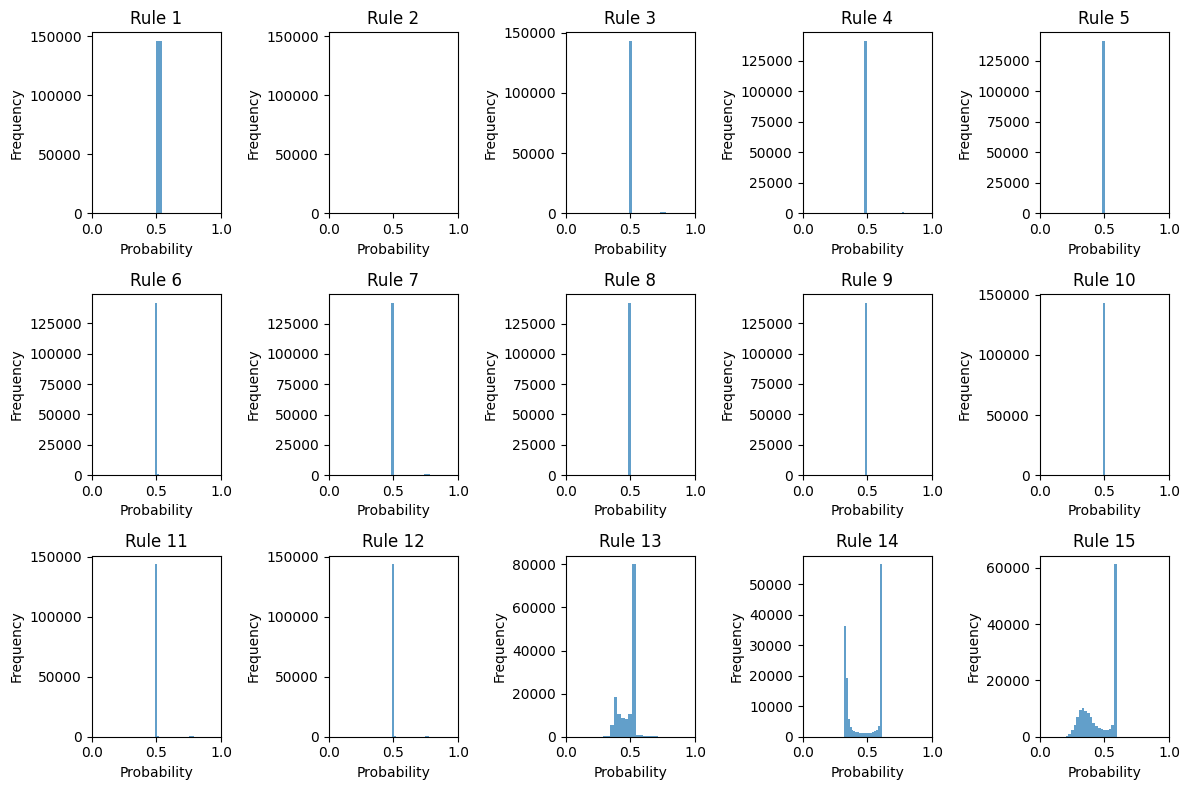

Test Accuracy: 0.9196
True Positive Rate (Recall): 71.56%
True Negative Rate: 93.83%
F1 Score: 0.7944
Average Precision: 0.7004
False Positive Rate: 0.0239

Confusion Matrix:
 [[111601   2728]
 [  9006  22665]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.93      0.98      0.95    114329
         1.0       0.89      0.72      0.79     31671

    accuracy                           0.92    146000
   macro avg       0.91      0.85      0.87    146000
weighted avg       0.92      0.92      0.92    146000

CPU times: total: 8.2 s
Wall time: 8.2 s


In [68]:
%%time
class ANFIS:
    def __init__(self, n_clusters, n_features, n_classes, X_train, random_state=42):
        self.n_clusters = n_clusters
        self.n_features = n_features
        self.n_classes = n_classes

        # Initialize cluster centers over the range of the features
        self.cluster_centers_ = np.array([
            np.linspace(np.min(X_train[:, i]), np.max(X_train[:, i]), n_clusters)
            for i in range(n_features)
        ]).T
        
        # Calculate standard deviation as range divided by (n_clusters - 1)
        self.std_devs_ = (np.max(X_train, axis=0) - np.min(X_train, axis=0)) / (n_clusters - 1)
        self.std_devs_ = np.tile(self.std_devs_, (n_clusters, 1))

        # Initialize RidgeClassifiers for consequent
        self.ridge_classifiers = [RidgeClassifier(alpha=1.0, solver='lsqr') for _ in range(n_clusters)]
        
        # Initialize SGDClassifier for updating cluster centers
        self.sgd_classifiers = [SGDClassifier(loss='log_loss', learning_rate='constant', eta0=0.1, fit_intercept=False, alpha=1.0) for _ in range(n_clusters)]


    def _fuzzyfication(self, X):
        u = np.zeros((X.shape[0], self.n_clusters))
        for i in range(self.n_clusters):
            std_dev = np.maximum(self.std_devs_[i], 1e-6)
            u[:, i] = np.prod(np.exp(-0.5 * (X - self.cluster_centers_[i])**2 / std_dev**2), axis=1)
        return u / np.sum(u, axis=1, keepdims=True)
        
    def fit(self, X_train, y_train, X_val, y_val, epochs=100, learning_rate=0.001, patience=20, threshold=0.5):
        best_val_accuracy = 0
        epochs_since_last_improvement = 0
        
        for epoch in range(epochs):
            u_train = self._fuzzyfication(X_train)
    
            # Update RidgeClassifier
            for r in range(self.n_clusters):
                weighted_X_train = X_train * u_train[:, r][:, np.newaxis]
                self.ridge_classifiers[r].fit(weighted_X_train, y_train)
    
            # Compute predictions
            y_preds = np.zeros((X_train.shape[0], self.n_clusters))
            for r in range(self.n_clusters):
                weighted_X_train = X_train * u_train[:, r][:, np.newaxis]
                y_preds[:, r] = self.ridge_classifiers[r].decision_function(weighted_X_train)
    
            weighted_preds = np.sum(y_preds * u_train, axis=1) / np.sum(u_train, axis=1)
            probabilities = 1 / (1 + np.exp(-weighted_preds))
            final_predictions = (probabilities >= threshold).astype(int)
            training_accuracy = accuracy_score(y_train, final_predictions)
    
            # Validation
            u_val = self._fuzzyfication(X_val)
            y_val_preds = np.zeros((X_val.shape[0], self.n_clusters))
            for r in range(self.n_clusters):
                weighted_X_val = X_val * u_val[:, r][:, np.newaxis]
                y_val_preds[:, r] = self.ridge_classifiers[r].decision_function(weighted_X_val)
    
            weighted_val_preds = np.sum(y_val_preds * u_val, axis=1) / np.sum(u_val, axis=1)
            probabilities_val = 1 / (1 + np.exp(-weighted_val_preds))
            val_final_predictions = (probabilities_val >= threshold).astype(int)
            validation_accuracy = accuracy_score(y_val, val_final_predictions)
    
            # Calculate loss
            loss = log_loss(y_train, weighted_preds)
    
            # Update cluster centers based on SGDClassifier
            for r in range(self.n_clusters):
                u_r = u_train[:, r]
    
                # Fit the SGD classifier
                weighted_X_train = u_r[:, np.newaxis] * X_train
                self.sgd_classifiers[r].partial_fit(weighted_X_train, y_train, classes=np.unique(y_train))




                # Update cluster centers
                self.cluster_centers_[r] -= self.sgd_classifiers[r].coef_[0][:self.n_features] * learning_rate

    
            print(f'Epoch {epoch + 1}/{epochs}, Training Accuracy: {training_accuracy:.4f}, Validation Accuracy: {validation_accuracy:.4f}, Loss: {loss:.4f}, Best Validation Accuracy: {best_val_accuracy:.4f}')
            
            if validation_accuracy > best_val_accuracy:
                best_val_accuracy = validation_accuracy
                epochs_since_last_improvement = 0
            else:
                epochs_since_last_improvement += 1
            
            if epochs_since_last_improvement >= patience:
                print(f'Early stopping triggered after {epoch + 1} epochs with best validation accuracy: {best_val_accuracy:.4f}')
                break
        
        self.print_rule_base()

    def print_rule_base(self):
        print("\nTuned Rule Base:")
        for i in range(self.n_clusters):
            rule = f"If "
            for j in range(self.n_features):
                mean = self.cluster_centers_[i][j]
                std_dev = self.std_devs_[i][j]
                rule += f"X{j+1} is ({mean:.3f}, {std_dev:.3f}) "
                if j < self.n_features - 1:
                    rule += "and "
            rule += f"then y = "

            cluster_coef = self.ridge_classifiers[i].coef_[0]
            cluster_intercept = self.ridge_classifiers[i].intercept_[0]

            for j in range(self.n_features):
                rule += f"{cluster_coef[j]:.2f} * X{j+1}"
                if j < self.n_features - 1:
                    rule += " + "
            rule += f" + {cluster_intercept:.2f}"
            print(rule)


    def test(self, X_test, y_test, threshold=0.5, sample_points=5):
        u_test = self._fuzzyfication(X_test)
        y_pred_test = np.zeros((X_test.shape[0], self.n_clusters))
        
        for r in range(self.n_clusters):
            weighted_X_test = X_test * u_test[:, r][:, np.newaxis]  # Corrected line
            y_pred_scores = self.ridge_classifiers[r].decision_function(weighted_X_test)
            y_pred_test[:, r] = y_pred_scores
        
        probabilities_test = 1 / (1 + np.exp(-y_pred_test))
        weighted_test_preds = np.sum(y_pred_test * u_test, axis=1) / np.sum(u_test, axis=1)
        final_probabilities = 1 / (1 + np.exp(-weighted_test_preds))  # Final probabilities for classification
        final_test_predictions = (final_probabilities >= threshold).astype(int) 
    
        print("\nProbabilities for each rule on first few test samples:")
        for i in range(min(sample_points, X_test.shape[0])):
            print(f"Sample {i + 1}:")
            for r in range(self.n_clusters):
                print(f"  Rule {r + 1}: Probability = {probabilities_test[i, r]:.4f}, Firing Strength = {u_test[i, r]:.4f}")
    
        plt.figure(figsize=(12, 8))
        for r in range(self.n_clusters):
            plt.subplot(3, 5, r + 1)
            plt.hist(probabilities_test[:, r], bins=20, alpha=0.7)
            plt.title(f'Rule {r + 1}')
            plt.xlabel('Probability')
            plt.ylabel('Frequency')
            plt.xlim(0, 1)
        
        plt.tight_layout()
        plt.show()
    
        test_accuracy = accuracy_score(y_test, final_test_predictions)
        true_positive_rate = recall_score(y_test, final_test_predictions)
        true_negative_rate = (y_test.shape[0] - confusion_matrix(y_test, final_test_predictions)[1, 0]) / y_test.shape[0]
        f1 = f1_score(y_test, final_test_predictions)
        average_precision = average_precision_score(y_test, final_test_predictions)
        fpr = confusion_matrix(y_test, final_test_predictions)[0, 1] / (confusion_matrix(y_test, final_test_predictions)[0, 1] + confusion_matrix(y_test, final_test_predictions)[0, 0])
        
        print(f'Test Accuracy: {test_accuracy:.4f}')
        print(f'True Positive Rate (Recall): {true_positive_rate * 100:.2f}%')
        print(f'True Negative Rate: {true_negative_rate * 100:.2f}%')
        print(f'F1 Score: {f1:.4f}')
        print(f'Average Precision: {average_precision:.4f}')
        print(f'False Positive Rate: {fpr:.4f}')
        
        cm = confusion_matrix(y_test, final_test_predictions)
        print("\nConfusion Matrix:\n", cm)
        
        report = classification_report(y_test, final_test_predictions, zero_division=0)
        print("\nClassification Report:\n", report)

    
    def save_model(self, filename):
        with open(filename, 'wb') as file:
            pickle.dump(self, file)
        print(f'Model saved to {filename}')

    @classmethod
    def load_model(cls, filename):
        with open(filename, 'rb') as file:
            model = pickle.load(file)
        print(f'Model loaded from {filename}')
        return model

# Example usage
n_clusters = 15  # Number of clusters
n_features = 10  # Update with actual feature count
n_classes = 2  # Update with actual class labels

# Split training data into training and validation sets
X_train_resampled, X_val, y_train_resampled, y_val = train_test_split(X_train_resampled, y_train_resampled, test_size=0.2, random_state=42)




# Fit the model with the resampled training data
# Fit the model with the resampled training data
model = ANFIS(n_clusters=n_clusters, n_features=n_features, n_classes=n_classes, X_train=X_train_resampled, random_state=42)
model.fit(X_train_resampled, y_train_resampled, X_val, y_val, epochs=100, learning_rate=0.1, patience=2000)

# Save the trained model
model.save_model('ANFIS-sgd.pkl')

# Load the model and test it with the original test data
loaded_model = ANFIS.load_model

# Load the model and test it with the original test data
loaded_model = ANFIS.load_model('ANFIS-sgd.pkl')
loaded_model.test(X_test, y_test, sample_points=1)  # Adjust sample_points as needed
# ready!!

# The End
